In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
# %env CUDA_VISIBLE_DEVICES=4
!nvidia-smi
%config InlineBackend.figure_format = 'retina'

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
Thu Aug  1 17:10:57 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.125.06   Driver Version: 525.125.06   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  On   | 00000000:01:00.0 Off |                    0 |
| N/A   46C    P0    68W / 275W |      0MiB / 81920MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100-SXM...  On   | 00000000:47:00.0 Off

In [2]:
import hydra
from hydra.utils import instantiate
from hydra import initialize, compose

In [3]:
import sys
import os
import getpass

os.chdir('/home/' + getpass.getuser() + '/Projects/CaloQVAE/')
sys.path.insert(1, '/home/' + getpass.getuser() + '/Projects/CaloQVAE/')

In [4]:
#external libraries
import os
import pickle
import datetime
import sys
import yaml
import json

import torch.optim as optim
import torch
from torch import nn
from torch.nn.functional import binary_cross_entropy_with_logits
torch.manual_seed(32)
import numpy as np
np.random.seed(32)
import matplotlib.pyplot as plt
import hydra
from hydra.utils import instantiate

from omegaconf import OmegaConf

import time

# PyTorch imports
from torch import device, load, save
from torch.nn import DataParallel
from torch.cuda import is_available

# Add the path to the parent directory to augment search for module
sys.path.append(os.getcwd())
    
# Weights and Biases
import wandb

#self defined imports
from CaloQVAE import logging

[17:11:02.283] INFO   CaloQVAE                                          Willkommen!
[17:11:02.284] INFO   CaloQVAE                                          Loading configuration.


In [5]:
logger = logging.getLogger(__name__)

from data.dataManager import DataManager
from utils.plotting.plotProvider import PlotProvider
from engine.engine import Engine
from models.modelCreator import ModelCreator

from utils.plotting.HighLevelFeatures import HighLevelFeatures as HLF
# HLF_1_photons = HLF('photon', filename='/raid/javier/Datasets/CaloVAE/data/atlas/binning_dataset_1_photons.xml', wandb=False)
# HLF_1_pions = HLF('pion', filename='/raid/javier/Datasets/CaloVAE/data/atlas/binning_dataset_1_pions.xml', wandb=False)
# HLF_1_electron = HLF('electron', filename='/raid/javier/Datasets/CaloVAE/data/atlas_dataset2and3/binning_dataset_2.xml', wandb=False)

2024-08-01 17:11:04,969 dwave.cloud INFO  MainThread Log level for 'dwave.cloud' namespace set to 0
[17:11:04.969] INFO   dwave.cloud                                       Log level for 'dwave.cloud' namespace set to 0


In [6]:
hydra.core.global_hydra.GlobalHydra.instance().clear()
initialize(version_base=None, config_path="../configs")

hydra.initialize()

In [7]:
# run_path= "/home/javier/Projects/CaloQVAE/outputs/2024-07-18/18-22-00/wandb/run-20240718_182201-5q976hf7/files/AtlasConditionalQVAE_atlas_default_best.pth"
# fn = create_filenames_dict(run_path)

In [7]:

# config=compose(config_name="config.yaml")
config=compose(config_name="config.yaml")

HLF_1_photons = HLF('photon', filename=config.data.binning_xml_photons, wandb=False)
HLF_1_pions = HLF('pion', filename=config.data.binning_xml_pions, wandb=False)
HLF_1_electron = HLF('electron', filename=config.data.binning_xml_electrons, wandb=False)

wandb.init(project="caloqvae", entity=config.data.entity, config=config, mode='disabled')
modelCreator = ModelCreator(cfg=config)
dataMgr = DataManager(cfg=config)
#initialise data loaders
dataMgr.init_dataLoaders()
#run pre processing: get/set input dimensions and mean of train dataset
dataMgr.pre_processing()

if config.model.activation_fct.lower()=="relu":
    modelCreator.default_activation_fct=torch.nn.ReLU()
elif config.model.activation_fct.lower()=="tanh":
    modelCreator.default_activation_fct=torch.nn.Tanh()
else:
    logger.warning("Setting identity as default activation fct")
    modelCreator.default_activation_fct=torch.nn.Identity()

#instantiate the chosen model
#loads from file 
model=modelCreator.init_model(dataMgr=dataMgr)

#create the NN infrastructure
model.create_networks()

/raid/javier/anaconda3/lib/python3.11/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'config.yaml': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)
[17:11:09.564] INFO   data.dataManager                                  Loading Data
[17:11:30.690] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f477fac1310>: 80000 events, 625 batches
[17:11:30.691] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f46ddf27550>: 10000 events, 10 batches
[17:11:30.691] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f46ddf26e90>: 10000 events, 10 batches
[17:11:33.056] INFO   models.modelCreator                               Initialising Model Type AtlasConditionalQVAE
2024-08-01 17:11:3

Initializing NetworkV3


In [8]:
#Not printing much useful info at the moment to avoid clutter. TODO optimise
model.print_model_info()
# for name, param in model.named_parameters():
#         print(name, param.requires_grad)

# Load the model on the GPU if applicable
# dev = None
# if (config.device == 'gpu') and config.gpu_list:
#     logger.info('Requesting GPUs. GPU list :' + str(config.gpu_list))
#     devids = ["cuda:{0}".format(x) for x in list(config.gpu_list)]
#     logger.info("Main GPU : " + devids[0])

#     if is_available():
#         print(devids[0])
#         dev = device(devids[0])
#         if len(devids) > 1:
#             logger.info(f"Using DataParallel on {devids}")
#             model = DataParallel(model, device_ids=list(config.gpu_list))
#         logger.info("CUDA available")
#     else:
#         dev = device('cpu')
#         logger.info("CUDA unavailable")
# else:
#     logger.info('Requested CPU or unable to use GPU. Setting CPU as device.')
#     dev = device('cpu')
# dev = torch.device("cuda:0")
dev = "cuda:{0}".format(config.gpu_list[0])

# Send the model to the selected device
# model.to(dev)
# Log metrics with wandb
wandb.watch(model)

# For some reason, need to use postional parameter cfg instead of named parameter
# with updated Hydra - used to work with named param but now is cfg=None 
engine=instantiate(config.engine, config)

#TODO for some reason hydra double instantiates the engine in a
#newer version if cfg=config is passed as an argument. This is a workaround.
#Find out why that is...
engine._config=config
#add dataMgr instance to engine namespace
engine.data_mgr=dataMgr
#add device instance to engine namespace
engine.device=dev    
#instantiate and register optimisation algorithm
engine.optimiser = torch.optim.Adam(model.parameters(),
                                    lr=config.engine.learning_rate)
#add the model instance to the engine namespace
engine.model = model
# add the modelCreator instance to engine namespace
engine.model_creator = modelCreator
engine.model = engine.model.to(dev)

[17:11:36.454] INFO   wandb                                             Watching
/raid/javier/anaconda3/lib/python3.11/site-packages/coffea/util.py:154: FutureWarning: In coffea version v2023.3.0 (target date: 31 Mar 2023), this will be an error.
(Set coffea.deprecations_as_errors = True to get a stack trace now.)
ImportError: coffea.hist is deprecated
  warnings.warn(message, FutureWarning)
[17:11:37.018] INFO   engine.engineAtlas                                Setting up engine Atlas.
[17:11:37.018] INFO   engine.engineCaloV3                               Setting up engine Calo.
[17:11:37.019] INFO   engine.engine                                     Setting up default engine.


In [9]:
train_loader,test_loader,val_loader = engine.data_mgr.create_dataLoader()

[17:11:59.349] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f45da950550>: 80000 events, 625 batches
[17:11:59.351] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f45da3e9d90>: 10000 events, 10 batches
[17:11:59.351] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f45da92ad90>: 10000 events, 10 batches


In [ ]:
engine.model._qpu_sampler.properties["chip_id"]

In [10]:

    
# # brisk-bird-447 | CNN + cond + scaled data + Cyl EncDec + lin/sqrt/log LONG energy encoded + CRBM 1st Partition Binv2 +scaled
run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-05-30/11-00-37/wandb/run-20240530_110038-oyw5vuog/files/AtlasConditionalQVAE_atlas_default_20.pth"
modelname = 'brisk-bird-447'
datascaled = 'reduced'
with open("/home/javier/Projects/CaloQVAE/outputs/2024-05-30/11-00-37/wandb/run-20240530_110038-oyw5vuog/files/config.yaml", 'r') as file:
    model_config = yaml.safe_load(file)
    R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
    reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
    scaled=False  
    
    
# #toasty-pond-448 | CNN + cond + scaled data + Cyl EncDec + lin/sqrt/log LONG energy encoded + CRBM 1st Partition Binv2 +scaled
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-05-30/16-39-43/wandb/run-20240530_163944-g59w6j0e/files/AtlasConditionalQVAE_atlas_default_140.pth"
# modelname = 'toasty-pond-448'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2024-05-30/16-39-43/wandb/run-20240530_163944-g59w6j0e/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=False
    
    
# # solar-cloud-449 | CNN + cond + scaled data + Cyl EncDec + lin/sqrt/log LONG energy encoded + CRBM 1st Partition Binv2 +scaled
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-05-30/19-04-18/wandb/run-20240530_190419-42l10ppy/files/AtlasConditionalQVAE_atlas_default_20.pth"
# modelname = 'solar-cloud-449'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2024-05-30/19-04-18/wandb/run-20240530_190419-42l10ppy/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=False 


# twilight-river-450 | CNN + cond + scaled data + Cyl EncDec + lin/sqrt/log LONG energy encoded + CRBM 1st Partition Binv2 +scaled
run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-05-31/19-11-05/wandb/run-20240531_191106-4dsnfwl4/files/GumBoltAtlasPRBMCNN_atlas_default_150.pth"
modelname = 'twilight-river-450'
datascaled = 'reduced'
with open("/home/javier/Projects/CaloQVAE/outputs/2024-05-31/19-11-05/wandb/run-20240531_191106-4dsnfwl4/files/config.yaml", 'r') as file:
    model_config = yaml.safe_load(file)
    R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
    reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
    scaled=False 


#helpful-star-450 | CNN + cond + scaled data + Cyl EncDec + lin/sqrt/log LONG energy encoded + CRBM 1st Partition Binv2 +scaled
run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-06-03/00-59-55/wandb/run-20240603_005956-nwgtxcyj/files/AtlasConditionalQVAE_atlas_default_120.pth"
modelname = 'helpful-star-450'
datascaled = 'reduced'
with open("/home/javier/Projects/CaloQVAE/outputs/2024-06-03/00-59-55/wandb/run-20240603_005956-nwgtxcyj/files/config.yaml", 'r') as file:
    model_config = yaml.safe_load(file)
    R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
    reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
    scaled=False
    
    
#glowing-meadow-453 | CNN + cond + scaled data + Cyl EncDec + lin/sqrt/log LONG energy encoded + CRBM 1st Partition Binv2 +scaled
run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-06-03/23-59-58/wandb/run-20240603_235959-1txgiuch/files/AtlasConditionalQVAE_atlas_default_100.pth"
modelname = 'glowing-meadow-453'
datascaled = 'reduced'
with open("/home/javier/Projects/CaloQVAE/outputs/2024-06-03/23-59-58/wandb/run-20240603_235959-1txgiuch/files/config.yaml", 'r') as file:
    model_config = yaml.safe_load(file)
    R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
    reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
    scaled=False


#honest-hill-454 | CNN + cond + scaled data + Cyl EncDec + lin/sqrt/log LONG energy encoded + CRBM 1st Partition Binv2 +scaled
run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-06-04/19-27-16/wandb/run-20240604_192717-n57xkuzr/files/AtlasConditionalQVAE_atlas_default_150.pth"
modelname = 'honest-hill-454'
datascaled = 'reduced'
with open("/home/javier/Projects/CaloQVAE/outputs/2024-06-04/19-27-16/wandb/run-20240604_192717-n57xkuzr/files/config.yaml", 'r') as file:
    model_config = yaml.safe_load(file)
    R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
    reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
    scaled=False
    
    
# #pretty-shape-455 | CNN + cond + scaled data + Cyl EncDec + lin/sqrt/log LONG energy encoded + CRBM 1st Partition Binv2 +scaled
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-06-05/03-07-35/wandb/run-20240605_030736-20kaac85/files/AtlasConditionalQVAE_atlas_default_150.pth"
# modelname = 'pretty-shape-455'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2024-06-05/03-07-35/wandb/run-20240605_030736-20kaac85/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=False



# #wobbly-aardvark-456 | CNN + cond + scaled data + Cyl EncDec + lin/sqrt/log LONG energy encoded + CRBM 1st Partition Binv2 +scaled
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-06-06/12-49-34/wandb/run-20240606_124935-30h7h1uj/files/AtlasConditionalQVAE_atlas_default_100.pth"
# modelname = 'wobbly-aardvark-456'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2024-06-06/12-49-34/wandb/run-20240606_124935-30h7h1uj/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=False

#bumbling-water-466 | CNN + cond + scaled data + Cyl EncDec + lin/sqrt/log LONG energy encoded + CRBM 1st Partition Binv2 +scaled
run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-06-19/20-29-26/wandb/run-20240619_202927-hxj10v27/files/AtlasConditionalQVAE_atlas_default_best.pth"
modelname = 'bumbling-water-466'
datascaled = 'reduced'
with open("/home/javier/Projects/CaloQVAE/outputs/2024-06-19/20-29-26/wandb/run-20240619_202927-hxj10v27/files/config.yaml", 'r') as file:
    model_config = yaml.safe_load(file)
    R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
    reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
    scaled=False
    cond = True
    
    
# dutiful-gorge-467 | No cond
run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-06-19/21-57-11/wandb/run-20240619_215713-vxgkius3/files/GumBoltAtlasPRBMCNN_atlas_default_best.pth"
modelname = 'dutiful-gorge-467'
datascaled = 'reduced'
with open("/home/javier/Projects/CaloQVAE/outputs/2024-06-19/21-57-11/wandb/run-20240619_215713-vxgkius3/files/config.yaml", 'r') as file:
    model_config = yaml.safe_load(file)
    R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
    reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
    scaled=False
    cond = False


# #mild-salad-468 | CNN + cond + scaled data + Cyl EncDec + lin/sqrt/log LONG energy encoded + CRBM 1st Partition Binv2 +scaled 0.005
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-06-24/20-03-04/wandb/run-20240624_200305-9z1n9jhb/files/AtlasConditionalQVAE_atlas_default_150.pth"
# modelname = 'mild-salad-468'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2024-06-24/20-03-04/wandb/run-20240624_200305-9z1n9jhb/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=False
#     cond = True


#morning-bush-469 | CNN + cond + scaled data + Cyl EncDec + lin/sqrt/log LONG energy encoded + CRBM 1st Partition Binv2 +scaled
run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-06-24/20-05-50/wandb/run-20240624_200551-lejg0j91/files/AtlasConditionalQVAE_atlas_default_150.pth"
modelname = 'morning-bush-469'
datascaled = 'reduced'
with open("/home/javier/Projects/CaloQVAE/outputs/2024-06-24/20-05-50/wandb/run-20240624_200551-lejg0j91/files/config.yaml", 'r') as file:
    model_config = yaml.safe_load(file)
    R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
    reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
    scaled=False
    cond = True
    
    
# #flowing-energy-471 | CNN + cond + scaled data + Cyl EncDec + lin/sqrt/log LONG energy encoded + CRBM 1st Partition Binv2 +scaled 0.005
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-06-27/14-36-20/wandb/run-20240627_143621-t4xwn93t/files/AtlasConditionalQVAE_atlas_default_150.pth"
# modelname = 'flowing-energy-471'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2024-06-27/14-36-20/wandb/run-20240627_143621-t4xwn93t/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=False
#     cond = True
    
    
# #crisp-wildflower-472 | CNN + cond + scaled data + Cyl EncDec + lin/sqrt/log LONG energy encoded + CRBM 1st Partition Binv2 +scaled 
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-06-27/14-39-50/wandb/run-20240627_143952-x09rgjmp/files/AtlasConditionalQVAE_atlas_default_150.pth"
# modelname = 'crisp-wildflower-472'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2024-06-27/14-39-50/wandb/run-20240627_143952-x09rgjmp/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=False
#     cond = True
    
# #peachy-elevator-473 | CNN + cond + scaled data + Cyl EncDec + lin/sqrt/log LONG energy encoded + CRBM 1st Partition Binv2 +scaled 
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-06-27/14-42-27/wandb/run-20240627_144228-4sttgocs/files/GumBoltAtlasPRBMCNN_atlas_default_best.pth"
# modelname = 'peachy-elevator-473'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2024-06-27/14-42-27/wandb/run-20240627_144228-4sttgocs/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=False
#     cond = False


#resilient-surf-478 | CNN + cond + scaled data + Cyl EncDec + lin/sqrt/log LONG energy encoded + CRBM 1st Partition Binv2 +scaled
run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-07-10/13-42-20/wandb/run-20240710_134221-ygiq6eo4/files/AtlasConditionalQVAE_atlas_default_130.pth"
modelname = 'resilient-surf-478'
datascaled = 'reduced'
with open("/home/javier/Projects/CaloQVAE/outputs/2024-07-10/13-42-20/wandb/run-20240710_134221-ygiq6eo4/files/config.yaml", 'r') as file:
    model_config = yaml.safe_load(file)
    R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
    reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
    scaled=False
    cond = True
    

#earnest-frost-483 | CNN + cond + scaled data + Cyl EncDec + lin/sqrt/log LONG energy encoded + CRBM 1st Partition Binv2 +scaled
run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-07-18/18-22-00/wandb/run-20240721_142426-5q976hf7/files/AtlasConditionalQVAE_atlas_default_latest.pth"
modelname = 'earnest-frost-483'
datascaled = 'reduced'
with open("/home/javier/Projects/CaloQVAE/outputs/2024-07-10/13-42-20/wandb/run-20240710_134221-ygiq6eo4/files/config.yaml", 'r') as file:
    model_config = yaml.safe_load(file)
    R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
    reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
    scaled=False
    cond = True
    
# #stellar-terrain-484 | CNN + cond + scaled data + Cyl EncDec + lin/sqrt/log LONG energy encoded + CRBM 1st Partition Binv2 +scaled
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-07-21/15-00-55/wandb/run-20240723_132510-ycmoh4pu/files/AtlasConditionalQVAE_atlas_default_120.pth"
# modelname = 'stellar-terrain-484'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2024-07-10/13-42-20/wandb/run-20240710_134221-ygiq6eo4/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=False
#     cond = True

    
arch = config['model']['model_type']
part = config['data']['particle_type']
print(arch)
print(part)
print(scaled, reducedata, R)


# load_state(model, run_path, 'cuda:{0}'.format(cfg.gpu_list[0]))
# load_state(model, run_path, dev)
modelCreator.load_state(run_path, dev)
engine.model.eval();

[17:11:59.425] INFO   models.modelCreator                               Loading state
[17:11:59.522] INFO   models.modelCreator                               Loading weights from file : /home/javier/Projects/CaloQVAE/outputs/2024-07-18/18-22-00/wandb/run-20240721_142426-5q976hf7/files/AtlasConditionalQVAE_atlas_default_latest.pth


AtlasConditionalQVAE
electron-ds2
False True 1e-07
Loading weights for module =  _activation_fct
Loading weights for module =  _bce_loss
Loading weights for module =  _energy_activation_fct
Loading weights for module =  _hit_activation_fct
Loading weights for module =  _output_loss
Loading weights for module =  _hit_loss
Loading weights for module =  _hit_smoothing_dist_mod
Loading weights for module =  _inference_energy_activation_fct
Loading weights for module =  encoder
Loading weights for module =  prior
Loading weights for module =  decoder


In [ ]:
lnZais = engine.model.stater.AIS(30).detach().cpu().item()

In [ ]:
lnZrais = engine.model.stater.RAIS(20).detach().cpu().item()
print(lnZais, lnZrais)

In [ ]:
lnZais_rdm = engine_2.model.stater.AIS(30).detach().cpu().item()
lnZrais_rdm = engine_2.model.stater.RAIS(20).detach().cpu().item()
print(lnZais_rdm, lnZrais_rdm)

In [ ]:
import h5py
with h5py.File("/home/javier/RBM_weights.hdf5", 'w') as hdf_file:
    for key, value in engine.model.prior.weight_dict.items():
        # Each key-value pair in the dictionary becomes a dataset in the HDF5 file
        hdf_file.create_dataset(key, data=value.detach().cpu())
        
with h5py.File("/home/javier/RBM_biases.hdf5", 'w') as hdf_file:
    for key, value in engine.model.prior.bias_dict.items():
        # Each key-value pair in the dictionary becomes a dataset in the HDF5 file
        hdf_file.create_dataset(key, data=value.detach().cpu())

In [ ]:
# # hfont = {'fontname':'Helvetica'}
# # ds = {'electron-ds2':'Dataset 2', 'pion1':'Dataset 1: π'}

In [11]:
xx = next(iter(test_loader))
in_data, true_energy, in_data_flat = engine._preprocess(xx[0],xx[1]) # input , label

In [ ]:
print(in_data.shape)
plt.plot(in_data.cpu().numpy()[3,:])

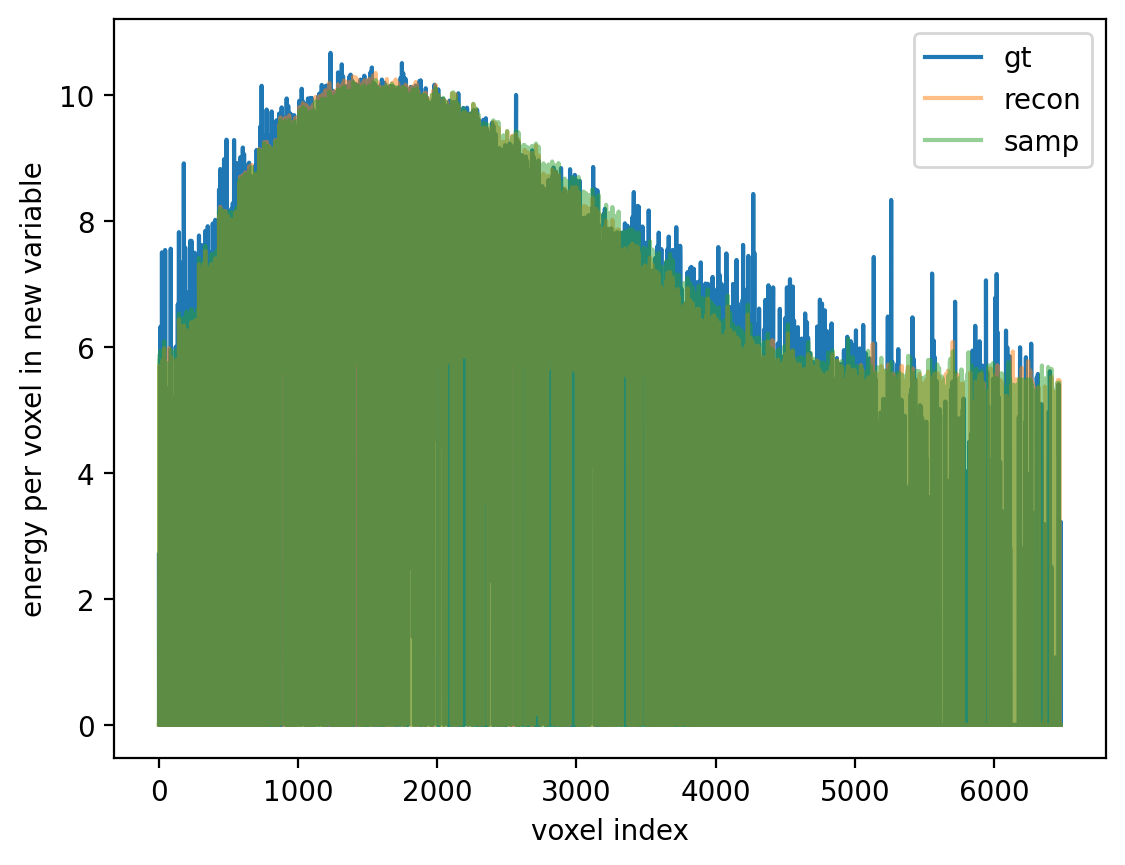

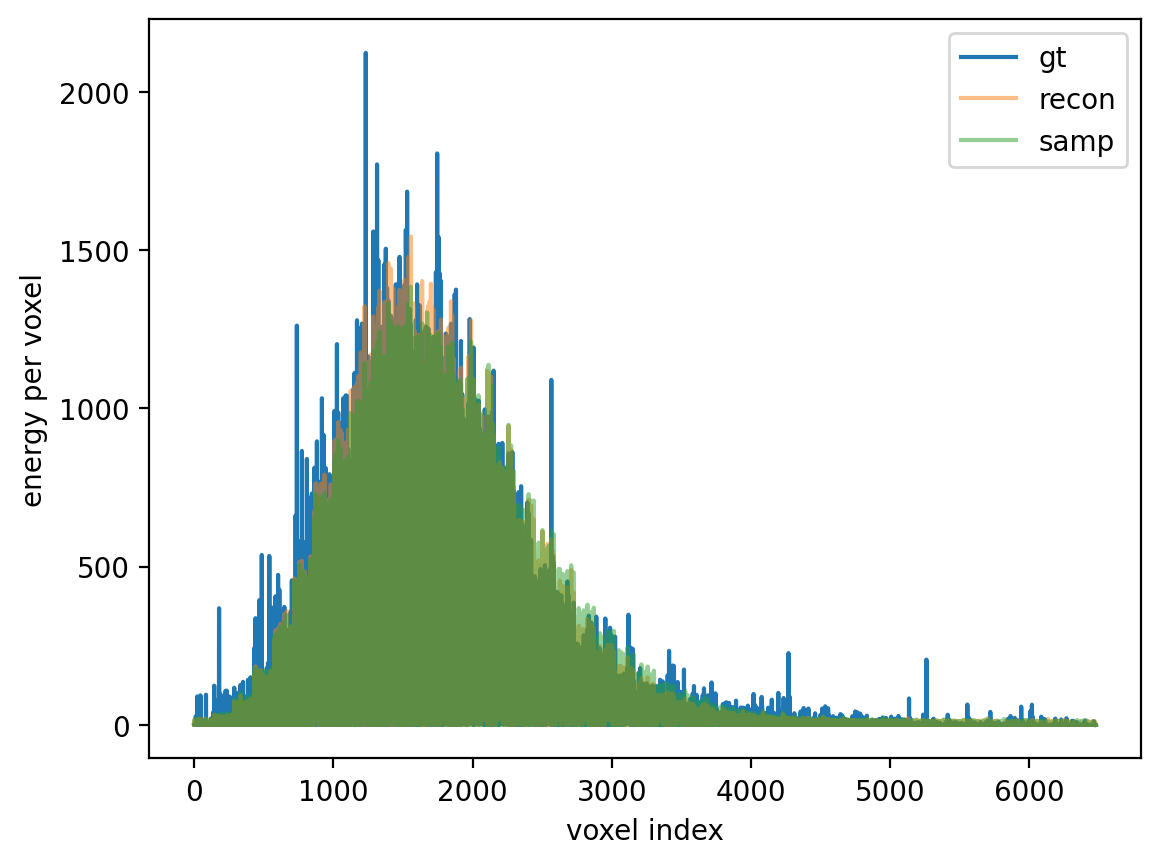

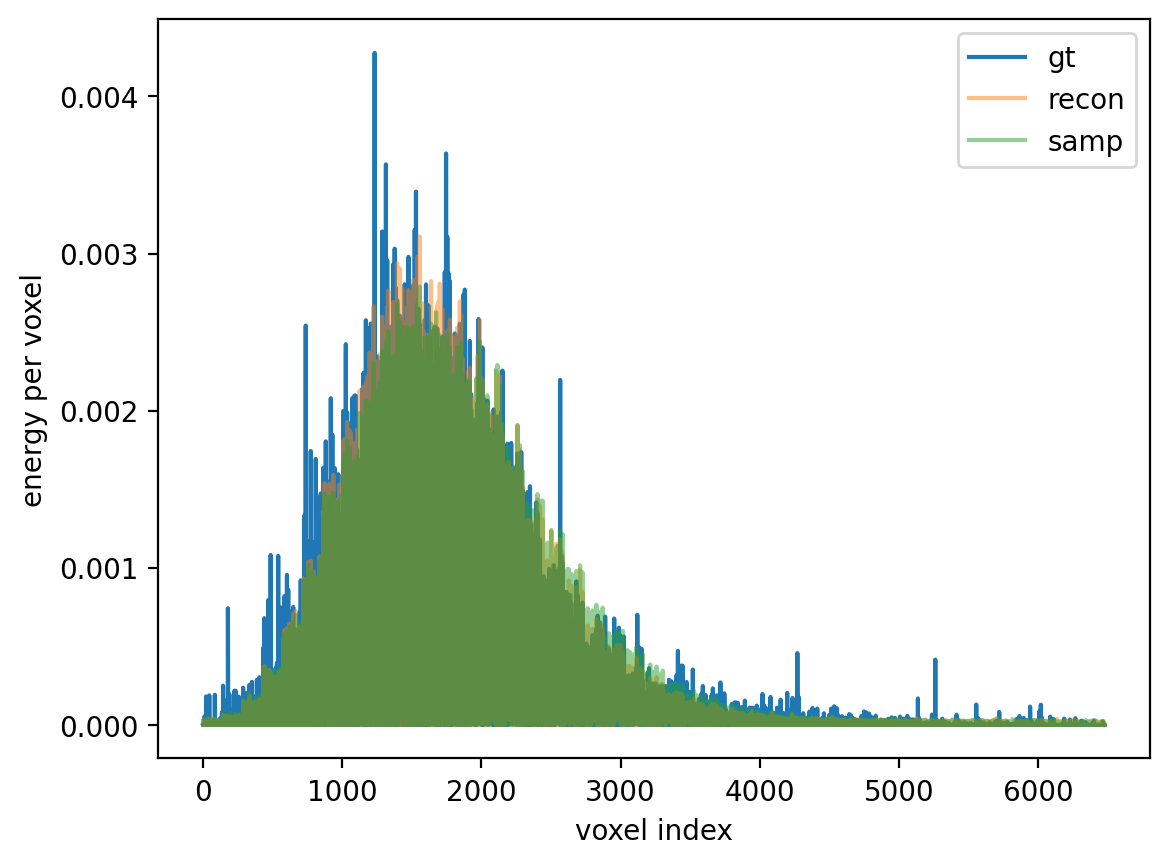

tensor([496389.0938], device='cuda:4') tensor(389130.5938, device='cuda:4')


In [13]:
with torch.no_grad():
    in_data, true_energy, in_data_flat = engine._preprocess(xx[0],xx[1])
    if True: #reducedata:
        in_data = engine._reduce(in_data, true_energy)
    fwd_output = engine.model((in_data, true_energy), True)
    engine._model.sampler._batch_size = true_energy.shape[0]
    if cond:
        sample_energies, sample_data = engine._model.generate_samples_cond(num_samples=true_energy.shape[0], true_energy=true_energy)
    else:
        sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy)
    engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
idx = 21
plt.plot(in_data.cpu().numpy()[idx,:])
plt.plot(fwd_output.output_activations.detach().cpu().numpy()[idx,:], alpha=0.5)
plt.plot(sample_data.detach().cpu().numpy()[idx,:], alpha=0.5)
plt.legend(["gt","recon","samp"])
plt.xlabel("voxel index")
plt.ylabel("energy per voxel in new variable")
plt.show()

plt.plot(engine._reduceinv(in_data,true_energy).cpu().numpy()[idx,:])
plt.plot(engine._reduceinv(fwd_output.output_activations,true_energy).detach().cpu().numpy()[idx,:], alpha=0.5)
plt.plot(engine._reduceinv(sample_data, true_energy).detach().cpu().numpy()[idx,:], alpha=0.5)
plt.legend(["gt","recon","samp"])
plt.xlabel("voxel index")
plt.ylabel("energy per voxel")
plt.show()

plt.plot(engine._reduceinv(in_data,true_energy).cpu().numpy()[idx,:]/true_energy.cpu().numpy()[idx,0])
plt.plot(engine._reduceinv(fwd_output.output_activations,true_energy).detach().cpu().numpy()[idx,:]/true_energy.cpu().numpy()[idx,0], alpha=0.5)
plt.plot(engine._reduceinv(sample_data, true_energy).detach().cpu().numpy()[idx,:]/true_energy.cpu().numpy()[idx,0], alpha=0.5)
plt.legend(["gt","recon","samp"])
plt.xlabel("voxel index")
plt.ylabel("energy per voxel")
plt.show()
print(true_energy[idx,:], engine._reduceinv(in_data, true_energy)[idx,:].sum())

In [263]:
directory_path = f'/home/javier/Projects/CaloQVAE/figs/DWAVE'
if not os.path.isdir(directory_path):
    os.mkdir(directory_path) 
    print(modelname)
else:
    pass

earnest-frost-483


In [257]:
beta, beta_list, rbm_energy_list, dwave_energy_list, thrsh_met = engine.model.find_beta(num_reads=1000, beta_init=4.29, lr=0.01, num_epochs = 30, delta = 4.0, method = 2, TOL=True, const = 1.0, adaptive = True)
beta0 = beta

[17:39:37.141] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 0: beta = 4.29
[17:39:39.384] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 1: beta = 4.8605053888632765
[17:39:41.384] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 2: beta = 4.745565812088523
[17:39:43.354] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 3: beta = 4.690124636552089
[17:39:45.293] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 4: beta = 4.6288024614466154
[17:39:47.395] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 5: beta = 4.619912106926444
[17:39:49.225] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 6: beta = 4.594579375613277
[17:39:51.277] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 7: beta = 4.581435272318608
[17:39:53.215] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 8: beta = 4.560207535754007
[17:39:55.321] INFO   models.autoencoders.AtlasConditiona

In [258]:
# beta, beta_list, rbm_energy_list, dwave_energy_list, thrsh_met = engine.model.find_beta_cond(true_energy, num_reads=256, beta_init=4.41, lr=0.01, num_epochs = 30, delta = 4.0, method = 1, TOL=True, const = 1.0, adaptive = False)
# beta0 = beta

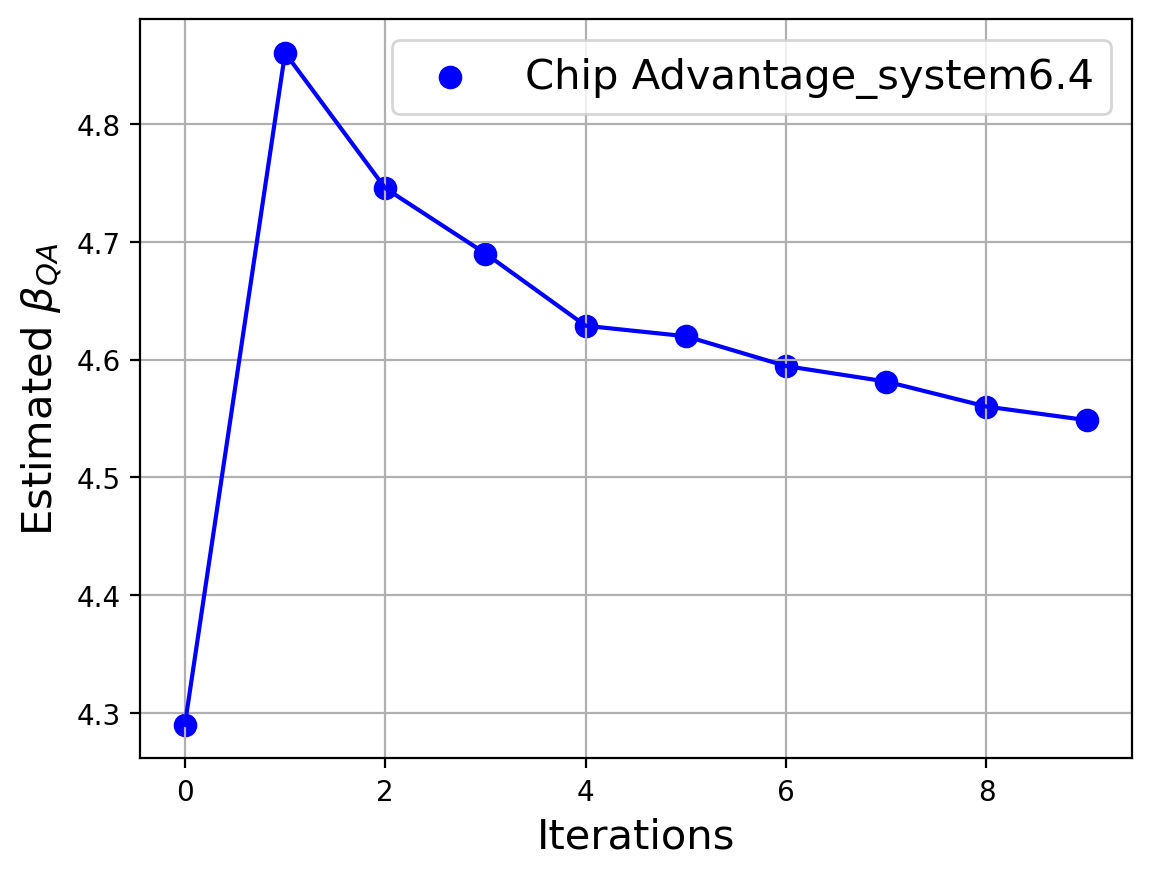

In [264]:
plt.scatter(range(len(beta_list)), beta_list, linewidth=2.5, color="b" )
plt.plot(range(len(beta_list)), beta_list, linewidth=1.5, color="b" )
plt.xlabel("Iterations", fontsize=15)
plt.ylabel("Estimated $β_{QA}$", fontsize=15)
plt.legend([f'Chip {engine.model._qpu_sampler.properties["chip_id"]}'], fontsize=15)
# plt.title(f'{ds[part]}')
plt.grid("True")
plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/DWAVE/beta_QA_{engine.model._qpu_sampler.properties["chip_id"]}_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()

In [260]:
QA = "$β_{QA}$"

In [261]:
Hoffset = -(sum([engine.model.prior.bias_dict[key].sum().detach().cpu().item() for key in engine.model.prior.bias_dict.keys()])/2 
            + sum([engine.model.prior.weight_dict[key].sum().detach().cpu().item() for key in engine.model.prior.weight_dict.keys()])/4)
print(Hoffset)

-365.3894200325012


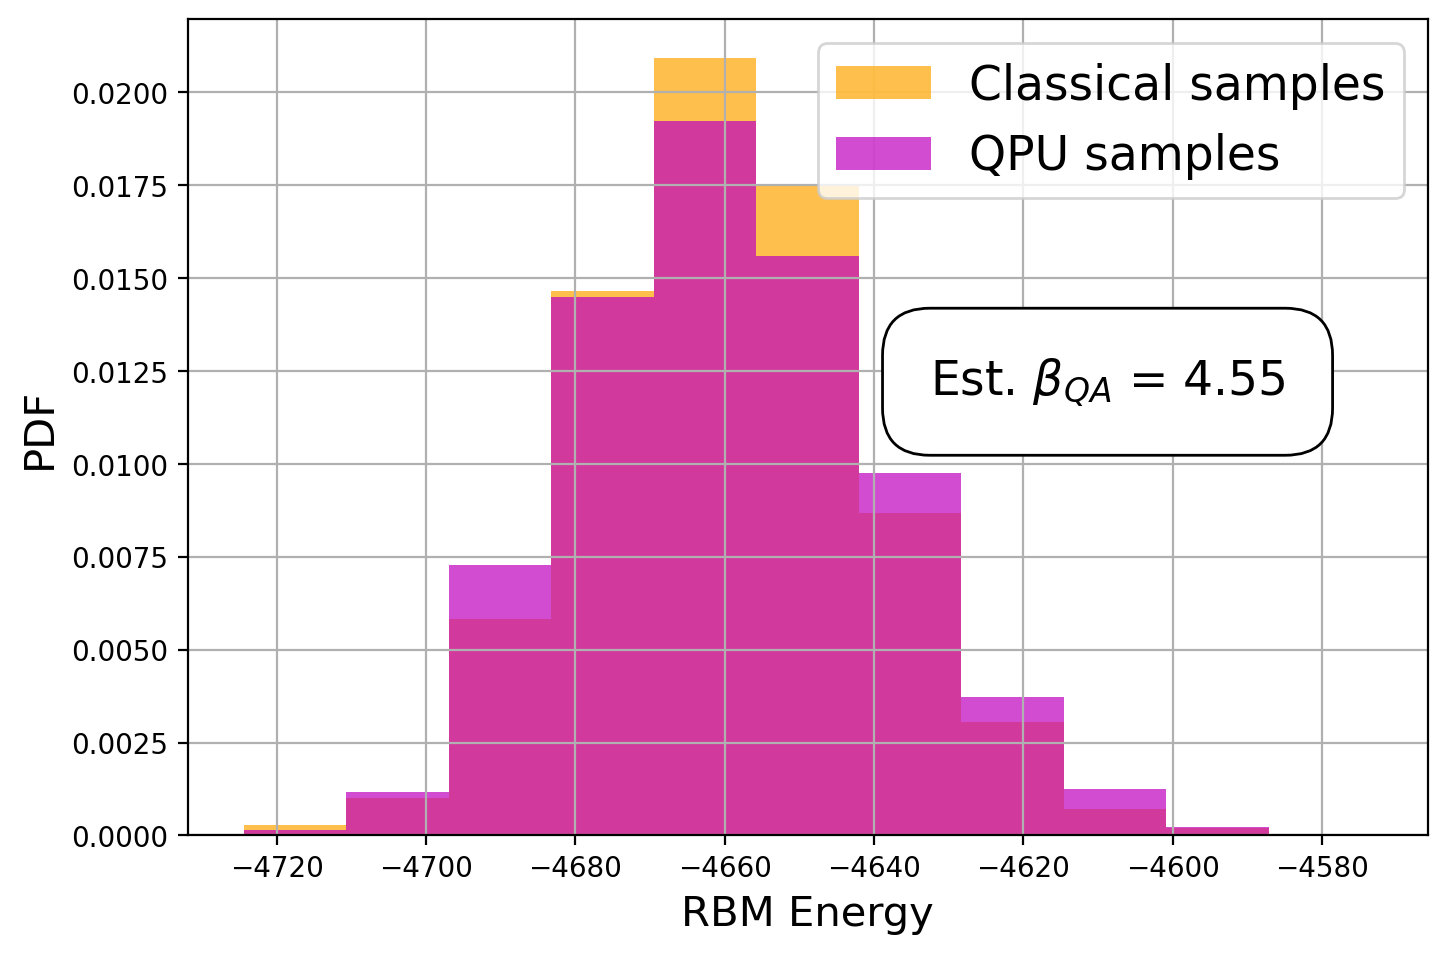

1024
1000


In [265]:
minVal, maxVal = min(dwave_energy_list[-1] + Hoffset), max(dwave_energy_list[-1] + Hoffset)
# minVal, maxVal = min(energy_dwave.detach().cpu().numpy()+ Hoffset/2), max(energy_dwave.detach().cpu().numpy()+ Hoffset/2)
binwidth = (maxVal-minVal)/10

plt.figure(figsize=(8,6))
plt.hist(rbm_energy_list[-1] + Hoffset, density=True, color="orange", alpha=0.7, bins=np.arange(minVal, maxVal + binwidth, binwidth))
plt.hist(dwave_energy_list[-1] + Hoffset, density=True, color="m", alpha=0.7, bins=np.arange(minVal, maxVal + binwidth, binwidth))
plt.xlabel("RBM Energy", fontsize=15)
plt.ylabel("PDF", fontsize=15)
plt.legend(["Classical samples", "QPU samples"], fontsize=17)
# plt.title(f'ln(Z)[AIS] = {np.round(Zais)}, ln(Z)[RAIS] = {np.round(Zrais)}')
plt.figtext(0.7, 0.6, f'Est. {QA} = {np.round(beta0, 2)}', ha='center', va='top', fontsize=17, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=1'))
plt.subplots_adjust(bottom=0.2)
plt.grid("True")
plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/DWAVE/Ising_energy_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()
print(len(rbm_energy_list[-1]))
print(len(dwave_energy_list[-1]))

In [ ]:
partition_size=config.model.n_latent_nodes_per_p
energy_encoded_data = []

engine.model.eval()
with torch.no_grad():
    for xx in val_loader:
        in_data, true_energy, in_data_flat = engine._preprocess(xx[0],xx[1])
        if reducedata:
            in_data = engine._reduce(in_data, true_energy, R=R)
        # enIn = torch.cat((in_data, true_energy), dim=1)
        # beta, post_logits, post_samples = engine.model.encoder(enIn, False)
        beta, post_logits, post_samples = engine.model.encoder(in_data, true_energy, False)
        post_samples = torch.cat(post_samples, 1)
        post_samples_energy = engine.model.stater.energy_samples(post_samples[:,0:partition_size], post_samples[:,partition_size:2*partition_size], 
                                                 post_samples[:,2*partition_size:3*partition_size], post_samples[:,3*partition_size:4*partition_size], 1.0 )
        energy_encoded_data.append(post_samples_energy.detach().cpu())

energy_encoded_data = torch.cat(energy_encoded_data, dim=0)

In [266]:
#####################################################
engine.model.prior_samples = []
sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy, measure_time=True)

In [267]:
h, J, qubit_idxs, idx_dict, dwave_weights, dwave_bias = engine.model.ising_model(1/beta0)

In [268]:
response_list = []
response_list.append( engine.model._qpu_sampler.sample_ising(h, J, num_reads=1000, answer_mode='raw', auto_scale=False, label="testing"))

In [269]:
response_array = response_list[0].record["sample"]

In [270]:
dwave_samples, dwave_energies, origSamples = engine.model.batch_dwave_samples(response_array, qubit_idxs)

In [271]:
dwave_samples = torch.tensor(dwave_samples, dtype=torch.float)
        
_ZERO = torch.tensor(0., dtype=torch.float)
_MINUS_ONE = torch.tensor(-1., dtype=torch.float)

dwave_samples = torch.where(dwave_samples == _MINUS_ONE, _ZERO, dwave_samples)

In [272]:
dwave_samples = dwave_samples.to(dev)

In [273]:
energy_dwave_2 = engine.model.stater.energy_samples(dwave_samples[:,0:512], dwave_samples[:,512:1024], 
                                                  dwave_samples[:,1024:1536], dwave_samples[:,1536:2048], 1.0)


In [49]:
import time

# time.sleep(2.5)

In [274]:
response_list = []
beta_list_2 = []
for i in range(1000):
    if i%100 == 0:
        print(i)
    # time.sleep(2.5)
    beta, beta_list, rbm_energy_list, dwave_energy_list, thrsh_met = engine.model.find_beta(num_reads=128, beta_init=4.29, lr=0.01, num_epochs = 30, delta = 4.0, method = 2, TOL=True, const = 1.0, adaptive = True)
    beta0 = beta
    beta_list_2.append(beta0)
    h, J, qubit_idxs, idx_dict, dwave_weights, dwave_bias = engine.model.ising_model(1/beta0)
    response_list.append( engine.model._qpu_sampler.sample_ising(h, J, num_reads=1, answer_mode='raw', auto_scale=False, programming_thermalization=10000, label=f'sampling 1 it: {i}'))

0


[17:45:16.881] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 0: beta = 4.29
[17:45:19.417] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 1: beta = 4.798223761440945
[17:45:22.010] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 2: beta = 4.720245230468346
[17:45:24.257] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 3: beta = 4.6939407132471835
[17:45:26.394] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 4: beta = 4.610771422452054
[17:45:30.645] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 0: beta = 4.29
[17:45:32.139] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 1: beta = 4.681209086280895
[17:45:33.690] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 2: beta = 4.550333354215951
[17:45:35.023] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 3: beta = 4.48882467096609
[17:45:36.353] INFO   models.autoencoders.AtlasConditionalQVAE          

100


[17:57:09.798] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 0: beta = 4.29
[17:57:11.125] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 1: beta = 4.387597143239998
[17:57:14.877] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 0: beta = 4.29
[17:57:16.285] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 1: beta = 4.381080911347451
[17:57:17.609] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 2: beta = 4.333567166161181
[17:57:21.293] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 0: beta = 4.29
[17:57:22.610] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 1: beta = 4.335456734443255
[17:57:23.996] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 2: beta = 4.360111164403994
[17:57:27.707] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 0: beta = 4.29
[17:57:29.035] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 1: beta = 4.38379067

200


[18:10:40.603] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 0: beta = 4.29
[18:10:41.980] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 1: beta = 4.372526065425016
[18:10:45.837] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 0: beta = 4.29
[18:10:47.165] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 1: beta = 4.371454234000052
[18:10:51.061] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 0: beta = 4.29
[18:10:52.370] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 1: beta = 4.494070129963436
[18:10:53.701] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 2: beta = 4.444542094537998
[18:10:55.128] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 3: beta = 4.366493372907427
[18:10:59.302] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 0: beta = 4.29
[18:11:00.634] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 1: beta = 4.44574663

300


[18:23:06.447] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 0: beta = 4.29
[18:23:07.851] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 1: beta = 4.394505926598769
[18:23:09.194] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 2: beta = 4.360691713454277
[18:23:13.257] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 0: beta = 4.29
[18:23:14.556] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 1: beta = 4.374610042278596
[18:23:15.899] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 2: beta = 4.410118814573837
[18:23:17.227] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 3: beta = 4.35619792921214
[18:23:20.920] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 0: beta = 4.29
[18:23:22.264] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 1: beta = 4.389912555871406
[18:23:23.599] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 2: beta 

400


[18:35:33.335] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 0: beta = 4.29
[18:35:34.655] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 1: beta = 4.36900418617786
[18:35:35.990] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 2: beta = 4.3468885211938275
[18:35:37.306] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 3: beta = 4.372524307955138
[18:35:41.383] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 0: beta = 4.29
[18:35:42.675] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 1: beta = 4.392328433276962
[18:35:46.422] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 0: beta = 4.29
[18:35:47.716] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 1: beta = 4.357698736861473
[18:35:51.580] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 0: beta = 4.29
[18:35:52.875] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 1: beta = 4.37714036

500


[18:46:58.549] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 0: beta = 4.29
[18:46:59.872] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 1: beta = 4.354396983967001
[18:47:01.300] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 2: beta = 4.3766132705545076
[18:47:05.589] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 0: beta = 4.29
[18:47:06.959] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 1: beta = 4.409036278578283
[18:47:08.302] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 2: beta = 4.3873981873082855
[18:47:09.605] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 3: beta = 4.364544362942331
[18:47:13.415] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 0: beta = 4.29
[18:47:14.743] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 1: beta = 4.343530381341402
[18:47:18.693] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 0: be

600


[18:58:35.499] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 0: beta = 4.29
[18:58:36.832] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 1: beta = 4.348309522607138
[18:58:40.897] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 0: beta = 4.29
[18:58:42.176] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 1: beta = 4.393017789909355
[18:58:43.587] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 2: beta = 4.365564526466682
[18:58:44.913] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 3: beta = 4.335292808059216
[18:58:46.187] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 4: beta = 4.314594960007999
[18:58:49.862] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 0: beta = 4.29
[18:58:51.165] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 1: beta = 4.3408738598988466
[18:58:52.462] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 2: bet

700


[19:11:12.641] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 0: beta = 4.29
[19:11:13.941] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 1: beta = 4.359963361571981
[19:11:17.666] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 0: beta = 4.29
[19:11:19.004] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 1: beta = 4.3507157610667635
[19:11:20.311] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 2: beta = 4.381192461649013
[19:11:21.643] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 3: beta = 4.345807474743374
[19:11:22.955] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 4: beta = 4.297548266308879
[19:11:26.734] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 0: beta = 4.29
[19:11:28.202] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 1: beta = 4.326621497975968
[19:11:29.499] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 2: bet

800


[19:23:23.300] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 0: beta = 4.29
[19:23:24.589] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 1: beta = 4.3376279520776215
[19:23:25.935] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 2: beta = 4.377791978521488
[19:23:29.790] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 0: beta = 4.29
[19:23:31.121] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 1: beta = 4.374022769303032
[19:23:32.390] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 2: beta = 4.028533773272883
[19:23:33.710] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 3: beta = 3.86958560401362
[19:23:35.007] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 4: beta = 3.73719652413537
[19:23:36.305] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 5: beta = 3.7145646161018764
[19:23:37.631] INFO   models.autoencoders.AtlasConditionalQVAE          

900


[19:36:10.080] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 0: beta = 4.29
[19:36:11.411] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 1: beta = 4.376075365947904
[19:36:12.890] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 2: beta = 4.304848829267059
[19:36:16.575] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 0: beta = 4.29
[19:36:17.898] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 1: beta = 4.398614940671109
[19:36:19.224] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 2: beta = 4.353921814915707
[19:36:20.803] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 3: beta = 4.327525511242537
[19:36:22.200] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 4: beta = 4.3646840367760795
[19:36:23.537] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 5: beta = 4.337644776861871
[19:36:27.275] INFO   models.autoencoders.AtlasConditionalQVAE         

In [275]:
response_array = np.concatenate([response_list[i].record["sample"] for i in range(len(response_list))])

In [276]:
dwave_samples, dwave_energies, origSamples = engine.model.batch_dwave_samples(response_array, qubit_idxs)

dwave_samples = torch.tensor(dwave_samples, dtype=torch.float)
        
_ZERO = torch.tensor(0., dtype=torch.float)
_MINUS_ONE = torch.tensor(-1., dtype=torch.float)

dwave_samples = torch.where(dwave_samples == _MINUS_ONE, _ZERO, dwave_samples)

dwave_samples = dwave_samples.to(dev)

energy_dwave_3 = engine.model.stater.energy_samples(dwave_samples[:,0:512], dwave_samples[:,512:1024], 
                                                  dwave_samples[:,1024:1536], dwave_samples[:,1536:2048], 1.0)


In [ ]:
engine.model.prior_samples_qpu = engine.model.prior_samples_qpu[-500:,:]
engine.model.prior_samples = engine.model.prior_samples[-500:,:]

In [278]:
# print(engine.model.prior_samples_qpu.shape)
print(engine.model.prior_samples.shape)

torch.Size([1024, 2048])


In [ ]:
print(True * True)
(engine.model.prior_samples_qpu[:,:512] == engine.model.prior_samples[:,:512]).prod()

In [279]:

# energy_dwave = engine.model.stater.energy_samples(engine.model.prior_samples_qpu[:,0:512], engine.model.prior_samples_qpu[:,512:1024], 
#                                                   engine.model.prior_samples_qpu[:,1024:1536], engine.model.prior_samples_qpu[:,1536:2048], 1.0)

energy_rbm_ = engine.model.stater.energy_samples(engine.model.prior_samples[:,0:512], engine.model.prior_samples[:,512:1024], 
                                                  engine.model.prior_samples[:,1024:1536], engine.model.prior_samples[:,1536:2048], 1.0)

# energy_dwave.shape

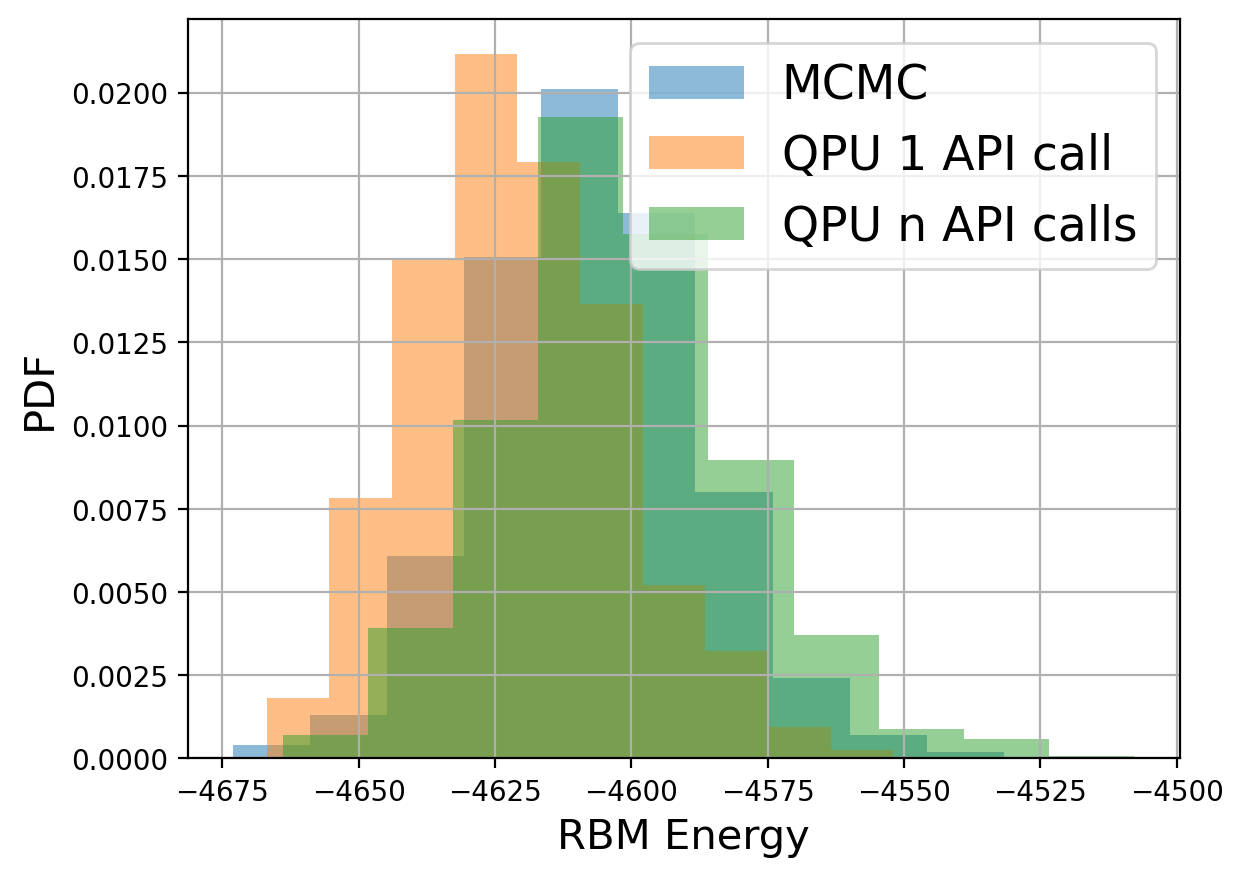

In [282]:
minVal, maxVal = min(energy_rbm_.detach().cpu().numpy()), max(energy_rbm_.detach().cpu().numpy())
binwidth = (maxVal-minVal)/10

# plt.hist(energy_dwave.detach().cpu(), bins=np.arange(minVal, maxVal + binwidth, binwidth), density=True)
plt.hist(energy_rbm_.detach().cpu(), alpha=0.5, density=True, bins=np.arange(minVal, maxVal + binwidth, binwidth), label="MCMC")
plt.hist(energy_dwave_2.detach().cpu(), alpha=0.5, density=True, bins=10, label="QPU 1 API call")
plt.hist(energy_dwave_3.detach().cpu(), alpha=0.5, density=True, bins=10, label="QPU n API calls")
plt.xlabel("RBM Energy", fontsize=15)
plt.ylabel("PDF", fontsize=15)
plt.grid(True)
plt.legend(fontsize=17)
plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/DWAVE/Comparison_MC_QPU1_QPUN_nbeta.png')
plt.show()
# print(rbm_data.shape, energy_rbm_data.detach().cpu().mean() - energy_dwave.detach().cpu().mean(),
#      energy_rbm_data.shape, energy_dwave.shape, Hoffset)

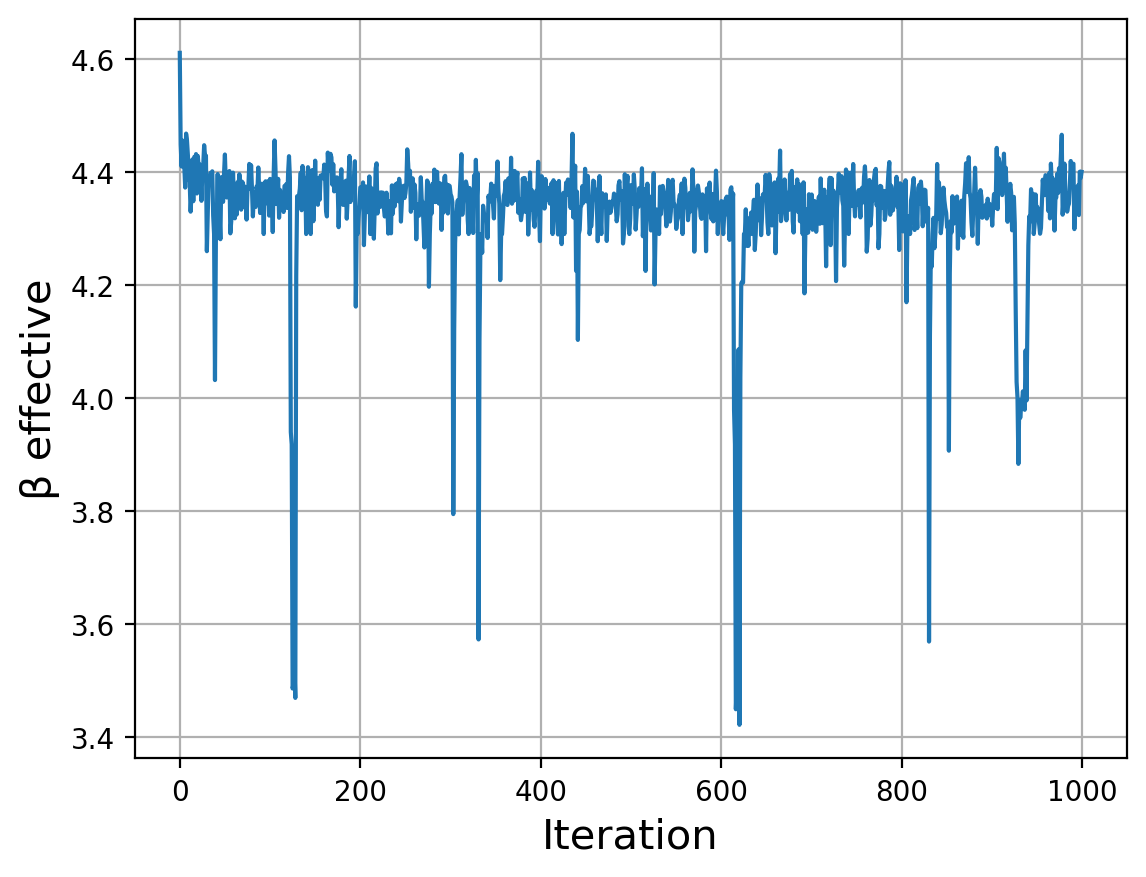

In [283]:
plt.plot(beta_list_2)
# plt.scatter(range(100), beta_list_2)
plt.grid("True")
plt.xlabel("Iteration", fontsize=15)
plt.ylabel("β effective", fontsize=15)
plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/DWAVE/beta_eff_Comparison_MC_QPU1_QPUN_nbeta.png')
plt.show()

In [286]:
np.savez(f'/home/javier/Projects/CaloQVAE/figs/DWAVE/Exp1_data.npz', rbm=energy_rbm_.detach().cpu().numpy(), qpu1=energy_dwave_2.detach().cpu().numpy(), 
         qpun = energy_dwave_3.detach().cpu().numpy(), beta=np.array(beta_list_2))

In [102]:
########################################################################################


In [298]:
#######################################
def classical_RBM(en_list = [10000], cond=True):  
    engine.model.prior_samples = []
    true_energy = torch.tensor(en_list).repeat(1024,1).to(dev)
    if cond:
        sample_energies, sample_data = engine._model.generate_samples_cond(num_samples=true_energy.shape[0], true_energy=true_energy, measure_time=True)
    else:
        sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy, measure_time=True)
    # print(engine.model.prior_samples.shape)
    energy_rbm_ = engine.model.stater.energy_samples(engine.model.prior_samples[:,0:512], engine.model.prior_samples[:,512:1024], 
                                                  engine.model.prior_samples[:,1024:1536], engine.model.prior_samples[:,1536:2048], 1.0)
    return energy_rbm_, engine.model.prior_samples[:,0:512]


def quantum_RBM(en_list = [10000], num_reads=2000, thrsh=20, cond=True):
    h, J, qubit_idxs, idx_dict, dwave_weights, dwave_bias = engine.model.ising_model(1/beta0)
    response_list = []

    true_energy = torch.tensor(en_list).repeat(1024,1).to(dev)
    u = engine.model.encoder.binary_energy(true_energy).to(dtype=torch.float32)
    x = next(iter(true_energy))
    fb = engine.model.gen_fb(1.0/beta0, x, thrsh=thrsh, cond=engine._config.qpu.cond, TOL=engine._config.qpu.tol)

    if cond:
        response_list.append( engine.model._qpu_sampler.sample_ising(h, J, num_reads=num_reads, answer_mode='raw', auto_scale=False, flux_drift_compensation=False, flux_biases=fb, label=f'Gen {num_reads} cond samples'))
    else:
        response_list.append( engine.model._qpu_sampler.sample_ising(h, J, num_reads=num_reads, answer_mode='raw', auto_scale=False, label=f'Gen {num_reads} samples'))
    response_array = response_list[0].record["sample"]
    dwave_samples, dwave_energies, origSamples = engine.model.batch_dwave_samples(response_array, qubit_idxs)

    dwave_samples = torch.tensor(dwave_samples, dtype=torch.float)

    _ZERO = torch.tensor(0., dtype=torch.float)
    _MINUS_ONE = torch.tensor(-1., dtype=torch.float)

    dwave_samples = torch.where(dwave_samples == _MINUS_ONE, _ZERO, dwave_samples)

    dwave_samples = dwave_samples.to(dev)

    energy_dwave_2 = engine.model.stater.energy_samples(dwave_samples[:,0:512], dwave_samples[:,512:1024], 
                                                      dwave_samples[:,1024:1536], dwave_samples[:,1536:2048], 1.0)
    if cond != True or (u[0,:].repeat(dwave_samples.shape[0],1) == dwave_samples[:,0:512]).prod() == 1:
        pass
    else:
        print(f'QPU encoding energy partition is not equal to the encoded energy for energy={en_list}')
    return energy_dwave_2, dwave_samples[:,0:512]


def find_the_energy_idx(en_label, true_energy):
    idx = (torch.isclose(true_energy, torch.tensor([en_label]).to(dev), atol=en_label/10)).nonzero(as_tuple=True)[0].detach().cpu()[0].item()
    # print(idx)
    return idx

def approx_post(true_energy, in_data, en_list = 10000.):
    partition_size=config.model.n_latent_nodes_per_p
    idx = find_the_energy_idx(en_list, true_energy)
    inc_en = true_energy[idx,0].repeat(1024,1)
    shower = in_data[idx,:].repeat(1024,1)
    engine.model.eval()
    with torch.no_grad():
        if reducedata:
            shower = engine._reduce(shower, inc_en, R=R)

        beta, post_logits, post_samples = engine.model.encoder(shower, inc_en, False)
        post_samples = torch.cat(post_samples, 1)
        post_samples_energy = engine.model.stater.energy_samples(post_samples[:,0:partition_size], post_samples[:,partition_size:2*partition_size], 
                                                 post_samples[:,2*partition_size:3*partition_size], post_samples[:,3*partition_size:4*partition_size], 1.0 )
    return post_samples_energy, post_samples[:,0:partition_size]



In [289]:
con = True
thrsh = 0

torch.Size([1024, 2048])
torch.Size([1024, 2048])
torch.Size([1024, 2048])
torch.Size([1024, 2048])
torch.Size([1024, 2048])


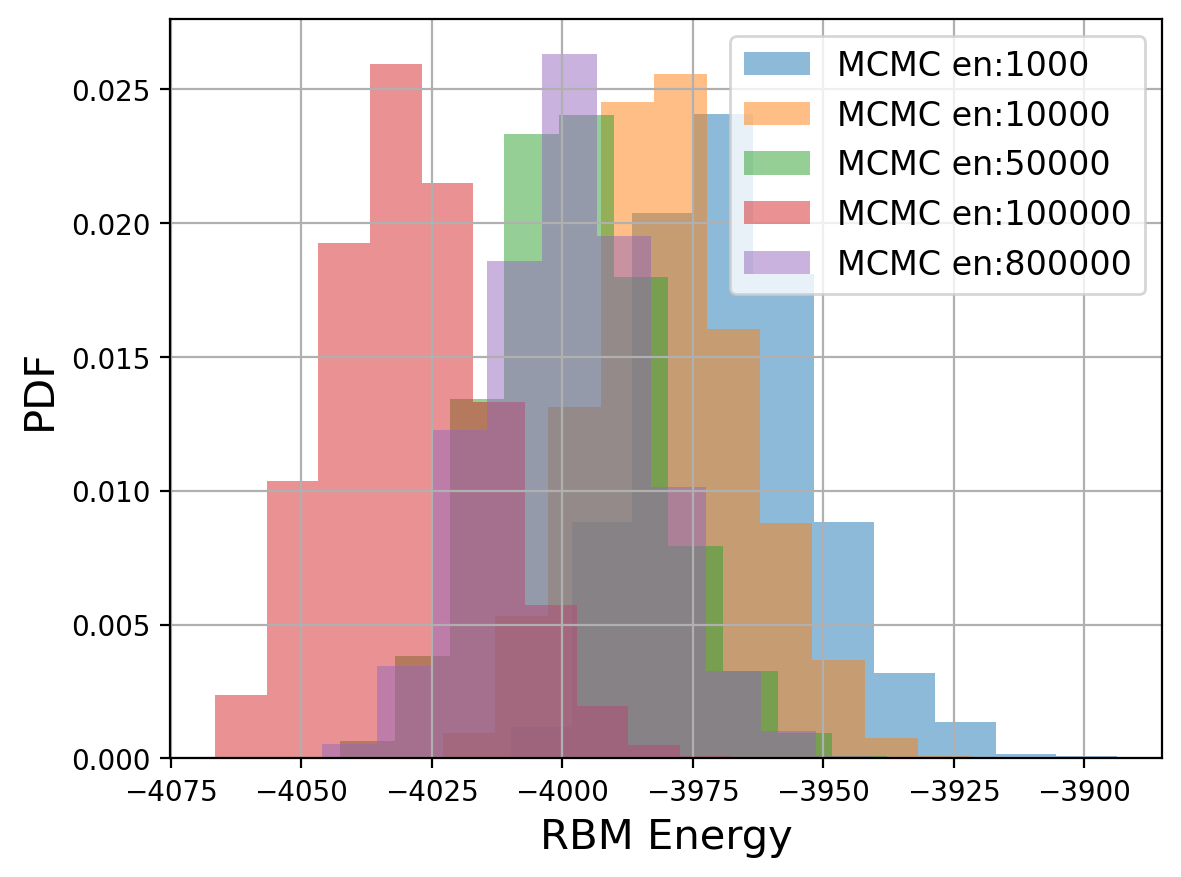

In [290]:
for i,en_label in enumerate([1000,10000,50000,100000,800000]):
    energy_rbm_, enc_energy = classical_RBM([en_label], cond=con)
    if i == 0:
        minVal, maxVal = min(energy_rbm_.detach().cpu().numpy()), max(energy_rbm_.detach().cpu().numpy())
        binwidth = (maxVal-minVal)/10

    plt.hist(energy_rbm_.detach().cpu(), alpha=0.5, density=True, bins=10, label=f'MCMC en:{en_label}') #np.arange(minVal, maxVal + binwidth, binwidth)
    # plt.hist(energy_dwave_2.detach().cpu(), alpha=0.5, density=True, bins=10, label="QPU 1 API call")
plt.xlabel("RBM Energy", fontsize=15)
plt.ylabel("PDF", fontsize=15)
plt.grid(True)
plt.legend(fontsize=12)
plt.show()

In [291]:
beta, beta_list, rbm_energy_list, dwave_energy_list, thrsh_met = engine.model.find_beta(num_reads=128, beta_init=4.29, lr=0.01, num_epochs = 30, delta = 4.0, method = 2, TOL=True, const = 1.0, adaptive = True)
beta0 = beta

[22:19:24.490] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 0: beta = 4.29
[22:19:26.728] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 1: beta = 4.744893489060606
[22:19:28.968] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 2: beta = 4.782296812323547
[22:19:31.216] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 3: beta = 4.723072879076962
[22:19:33.408] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 4: beta = 4.645880209737291
[22:19:34.978] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 5: beta = 4.610399016550431
[22:19:36.287] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 6: beta = 4.561262125201694
[22:19:37.596] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 7: beta = 4.513016398758396
[22:19:38.977] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 8: beta = 4.468284173435363
[22:19:40.328] INFO   models.autoencoders.AtlasConditionalQ

QPU encoding energy partition is not equal to the encoded energy for energy=[1000]
QPU encoding energy partition is not equal to the encoded energy for energy=[10000]
QPU encoding energy partition is not equal to the encoded energy for energy=[50000]
QPU encoding energy partition is not equal to the encoded energy for energy=[100000]
QPU encoding energy partition is not equal to the encoded energy for energy=[800000]


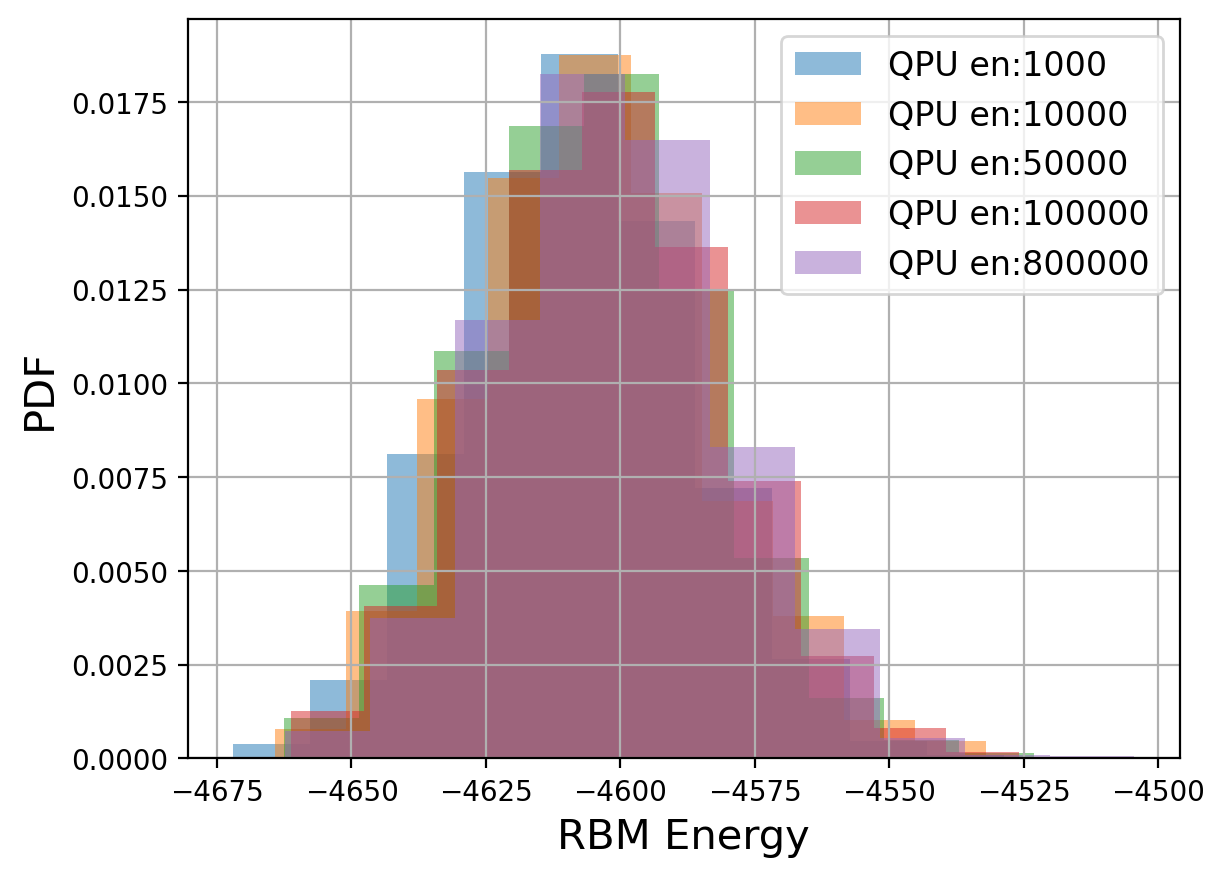

In [292]:
for i,en_label in enumerate([1000,10000,50000,100000,800000]):
    energy_dwave_2, enc_energy = quantum_RBM([en_label], cond=con, thrsh=thrsh)
    # if i == 0:
    #     minVal, maxVal = min(energy_rbm_.detach().cpu().numpy()), max(energy_rbm_.detach().cpu().numpy())
    #     binwidth = (maxVal-minVal)/10

    # plt.hist(energy_rbm_.detach().cpu(), alpha=0.5, density=True, bins=10, label=f'MCMC en:{en_label}') #np.arange(minVal, maxVal + binwidth, binwidth)
    plt.hist(energy_dwave_2.detach().cpu(), alpha=0.5, density=True, bins=10, label=f'QPU en:{en_label}')
plt.xlabel("RBM Energy", fontsize=15)
plt.ylabel("PDF", fontsize=15)
plt.grid(True)
plt.legend(fontsize=12)
plt.show()

torch.Size([1024, 2048])
torch.Size([1024, 2048])
torch.Size([1024, 2048])
torch.Size([1024, 2048])
torch.Size([1024, 2048])
torch.Size([1024, 2048])
torch.Size([1024, 2048])
torch.Size([1024, 2048])
torch.Size([1024, 2048])
torch.Size([1024, 2048])
torch.Size([1024, 2048])
torch.Size([1024, 2048])
torch.Size([1024, 2048])
torch.Size([1024, 2048])
torch.Size([1024, 2048])
torch.Size([1024, 2048])
torch.Size([1024, 2048])
torch.Size([1024, 2048])
torch.Size([1024, 2048])
torch.Size([1024, 2048])


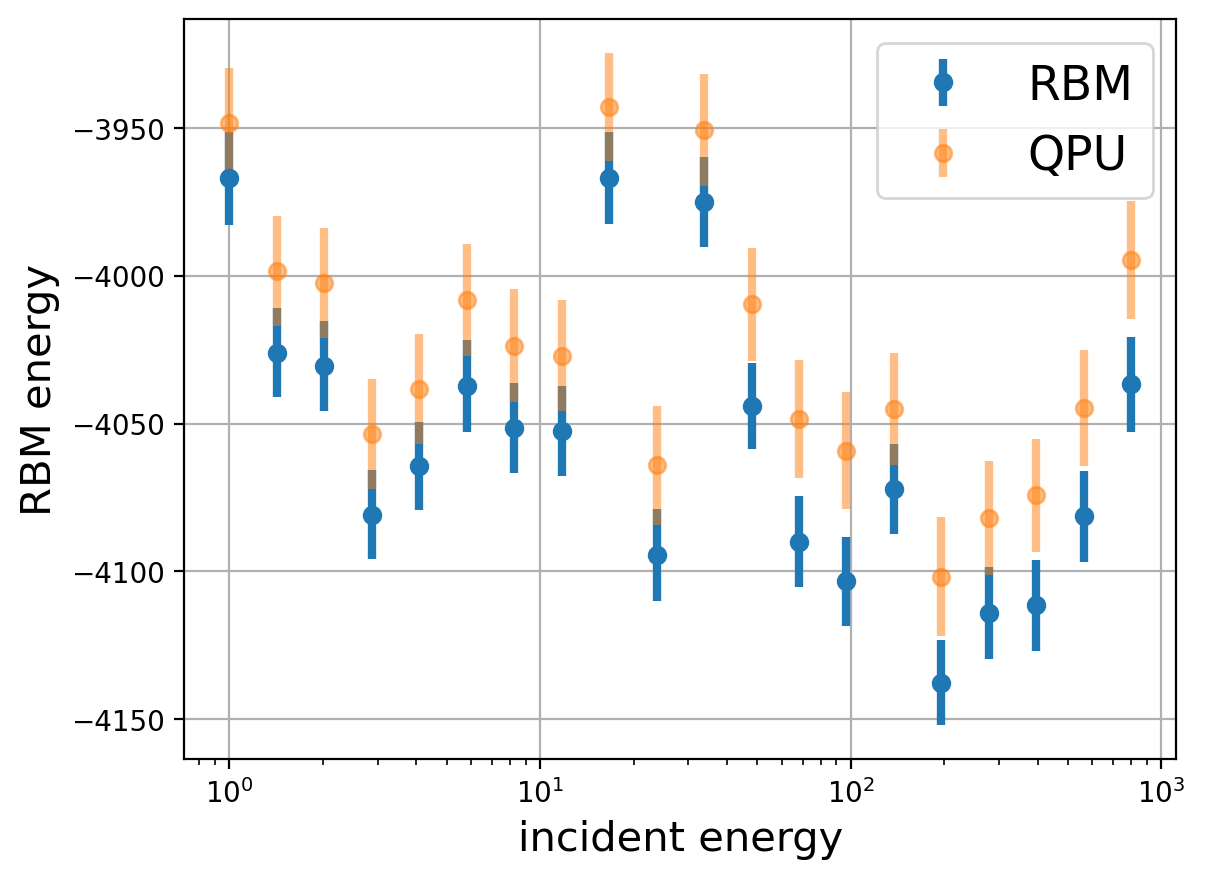

In [251]:
rbm_dict = {"en":[], "m":[], "s":[]}
qpu_dict = {"en":[], "m":[], "s":[]}
for i,en_label in enumerate(np.logspace(3.0, 5.903, num=20, dtype="float32")):
    energy_rbm_, enc_energy = classical_RBM([en_label], cond=con)
    energy_dwave_2, enc_energy = quantum_RBM([en_label], cond=con, thrsh=thrsh)
    
    rbm_dict["en"].append(en_label/1000)
    rbm_dict["m"].append(energy_rbm_.mean().detach().cpu().item())
    rbm_dict["s"].append(energy_rbm_.std().detach().cpu().item())
    
    qpu_dict["en"].append(en_label/1000)
    qpu_dict["m"].append(energy_dwave_2.mean().detach().cpu().item())
    qpu_dict["s"].append(energy_dwave_2.std().detach().cpu().item())

plt.errorbar(rbm_dict["en"], rbm_dict["m"], yerr=rbm_dict["s"], fmt="o", label="RBM", lw=3)
plt.errorbar(qpu_dict["en"], qpu_dict["m"], yerr=qpu_dict["s"], fmt="o", label="QPU", lw=3, alpha=0.5)
plt.xlabel("incident energy", fontsize=15)
plt.ylabel("RBM energy", fontsize=15)
plt.grid(True)
plt.legend(fontsize=17)
plt.xscale("log")
plt.show()

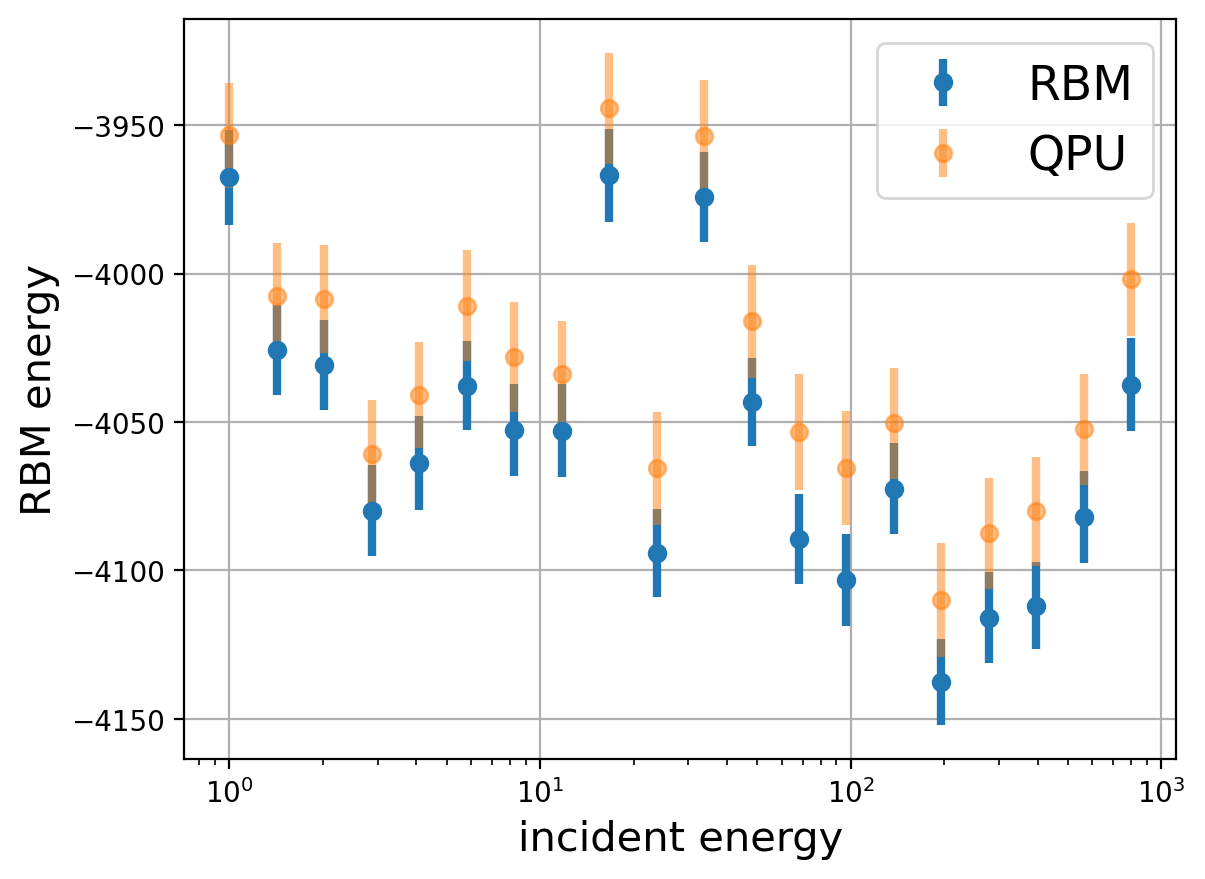

In [249]:
plt.errorbar(rbm_dict["en"], rbm_dict["m"], yerr=rbm_dict["s"], fmt="o", label="RBM", lw=3)
plt.errorbar(qpu_dict["en"], qpu_dict["m"], yerr=qpu_dict["s"], fmt="o", label="QPU", lw=3, alpha=0.5)
plt.xlabel("incident energy", fontsize=15)
plt.ylabel("RBM energy", fontsize=15)
plt.grid(True)
plt.legend(fontsize=17)
plt.xscale("log")
plt.show()

In [318]:
########## Comparison b.w. RBM,QPU and approx post
con = True
thrsh = 20.0

xx = next(iter(val_loader))
in_data, true_energy, in_data_flat = engine._preprocess(xx[0],xx[1])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


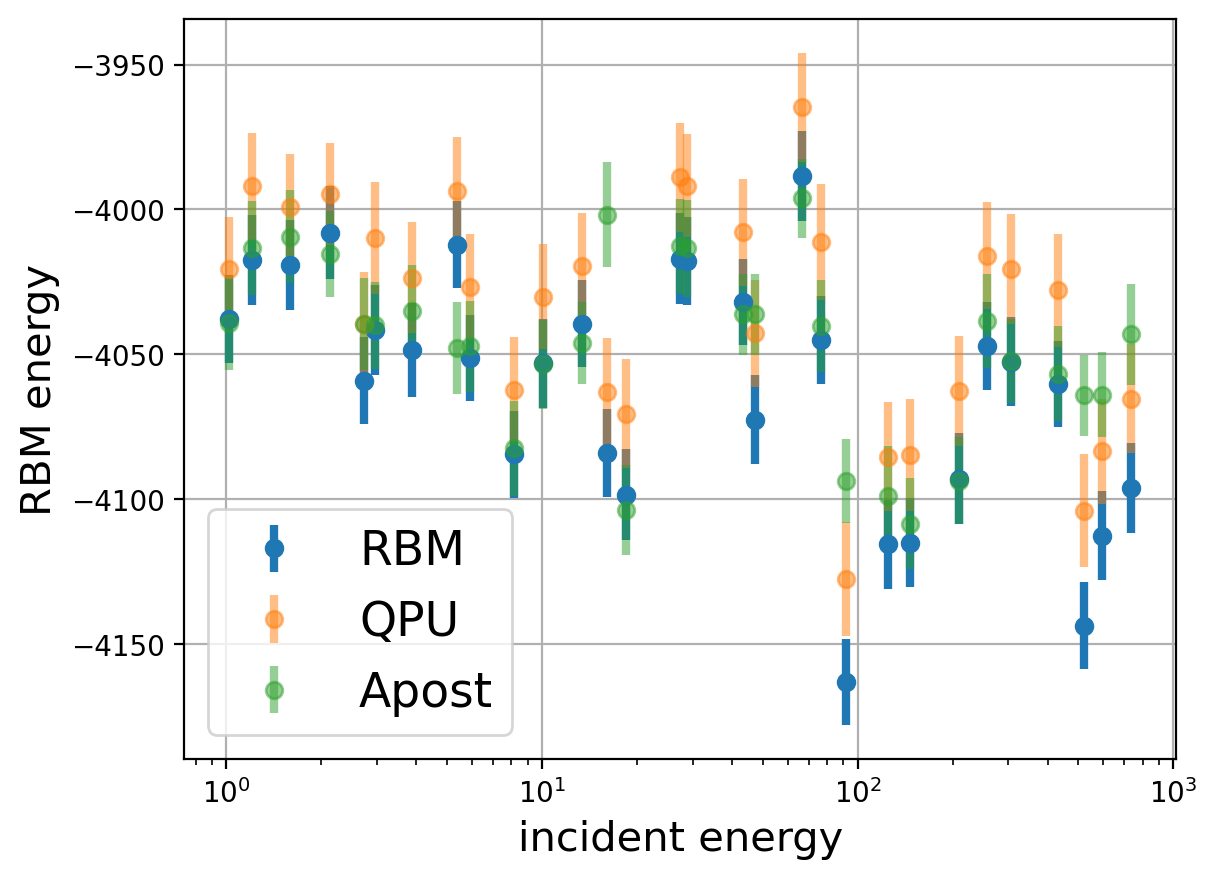

In [319]:
rbm_dict = {"en":[], "m":[], "s":[]}
qpu_dict = {"en":[], "m":[], "s":[]}
apost_dict = {"en":[], "m":[], "s":[]}
for i,en_label_ in enumerate(np.logspace(3.0, 5.903, num=30, dtype="float32")):
    print(i)
    idx = find_the_energy_idx(en_label_, true_energy)
    en_label = true_energy[idx,0].detach().cpu().item()
    energy_enc, enc_energy = approx_post(true_energy, in_data, en_label)
    
    energy_rbm_, enc_energy = classical_RBM([en_label], cond=con)
    energy_dwave_2, enc_energy = quantum_RBM([en_label], cond=con, thrsh=thrsh)
    
    rbm_dict["en"].append(en_label/1000)
    rbm_dict["m"].append(energy_rbm_.mean().detach().cpu().item())
    rbm_dict["s"].append(energy_rbm_.std().detach().cpu().item())
    
    qpu_dict["en"].append(en_label/1000)
    qpu_dict["m"].append(energy_dwave_2.mean().detach().cpu().item())
    qpu_dict["s"].append(energy_dwave_2.std().detach().cpu().item())
    
    apost_dict["en"].append(en_label/1000)
    apost_dict["m"].append(energy_enc.mean().detach().cpu().item())
    apost_dict["s"].append(energy_enc.std().detach().cpu().item())

plt.errorbar(rbm_dict["en"], rbm_dict["m"], yerr=rbm_dict["s"], fmt="o", label="RBM", lw=3)
plt.errorbar(qpu_dict["en"], qpu_dict["m"], yerr=qpu_dict["s"], fmt="o", label="QPU", lw=3, alpha=0.5)
plt.errorbar(apost_dict["en"], apost_dict["m"], yerr=apost_dict["s"], fmt="o", label="Apost", lw=3, alpha=0.5)
plt.xlabel("incident energy", fontsize=15)
plt.ylabel("RBM energy", fontsize=15)
plt.grid(True)
plt.legend(fontsize=17)
plt.xscale("log")
plt.show()

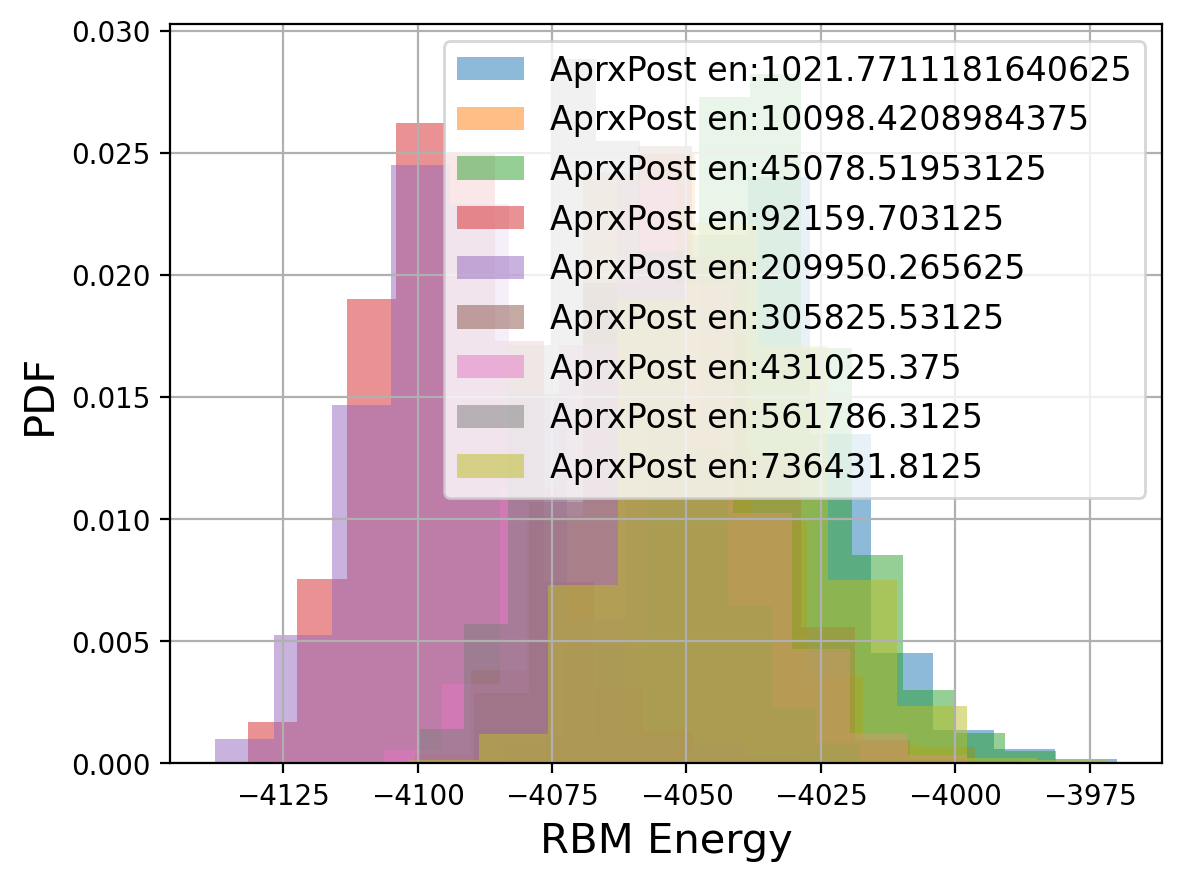

In [188]:
for i,en_label in enumerate([1000.,10000.,50000.,100000., 200000., 300000., 400000., 600000.,800000.]):
    idx = find_the_energy_idx(en_label, true_energy)
    en_label_idx = true_energy[idx,0].detach().cpu().item()
    energy_enc, enc_energy = approx_post(true_energy, in_data, en_label_idx)
    plt.hist(energy_enc.detach().cpu(), alpha=0.5, density=True, bins=10, label=f'AprxPost en:{en_label_idx}')
plt.xlabel("RBM Energy", fontsize=15)
plt.ylabel("PDF", fontsize=15)
plt.grid(True)
plt.legend(fontsize=12)
plt.show()

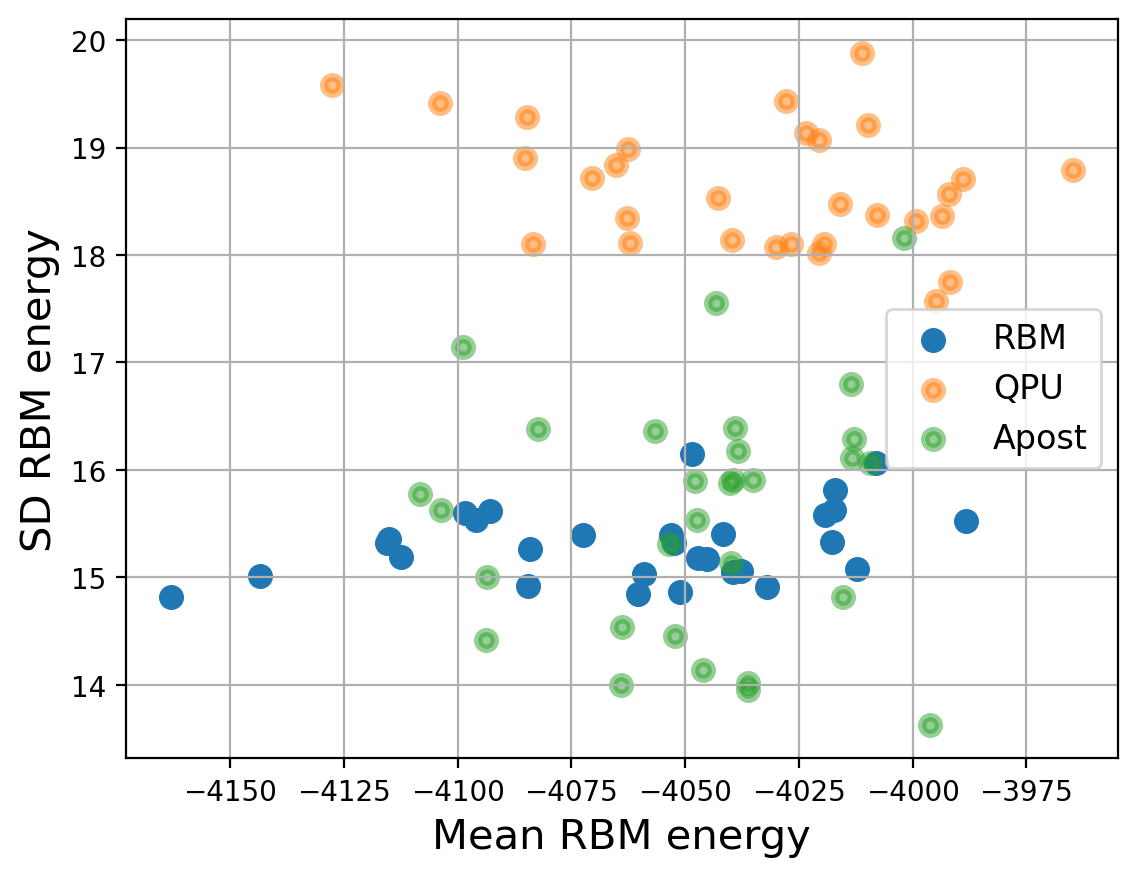

In [320]:
plt.scatter(rbm_dict["m"], rbm_dict["s"],  label="RBM", lw=3)
plt.scatter(qpu_dict["m"], qpu_dict["s"],  label="QPU", lw=3, alpha=0.5)
plt.scatter(apost_dict["m"], apost_dict["s"], label="Apost", lw=3, alpha=0.5)
plt.xlabel("Mean RBM energy", fontsize=15)
plt.ylabel("SD RBM energy", fontsize=15)
plt.grid(True)
plt.legend(fontsize=12)
plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/DWAVE/SD_vs_mean_Apost_MC_QPU_thrsh_{thrsh}.png')
plt.show()

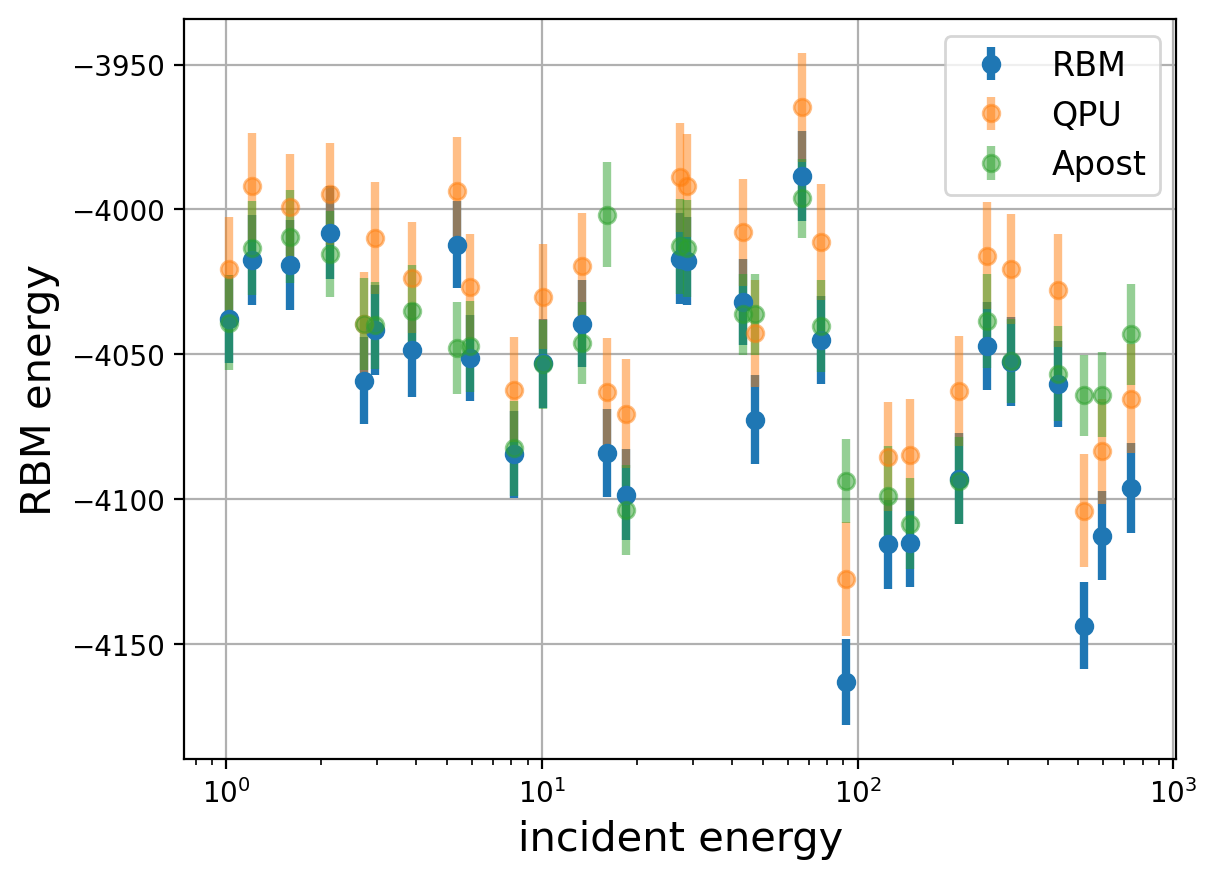

In [321]:
plt.errorbar(rbm_dict["en"], rbm_dict["m"], yerr=rbm_dict["s"], fmt="o", label="RBM", lw=3)
plt.errorbar(qpu_dict["en"], qpu_dict["m"], yerr=qpu_dict["s"], fmt="o", label="QPU", lw=3, alpha=0.5)
plt.errorbar(apost_dict["en"], apost_dict["m"], yerr=apost_dict["s"], fmt="o", label="Apost", lw=3, alpha=0.5)
plt.xlabel("incident energy", fontsize=15)
plt.ylabel("RBM energy", fontsize=15)
plt.grid(True)
plt.legend(fontsize=12)
plt.xscale("log")
plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/DWAVE/Comparison_Apost_MC_QPU_thrsh_{thrsh}.png')
plt.show()

In [ ]:
# np.savez(f'/home/javier/Projects/CaloQVAE/figs/DWAVE/Exp2_data.npz', rbm=energy_rbm_.detach().cpu().numpy(), qpu1=energy_dwave_2.detach().cpu().numpy(), 
         # qpun = energy_dwave_3.detach().cpu().numpy(), beta=np.array(beta_list_2))

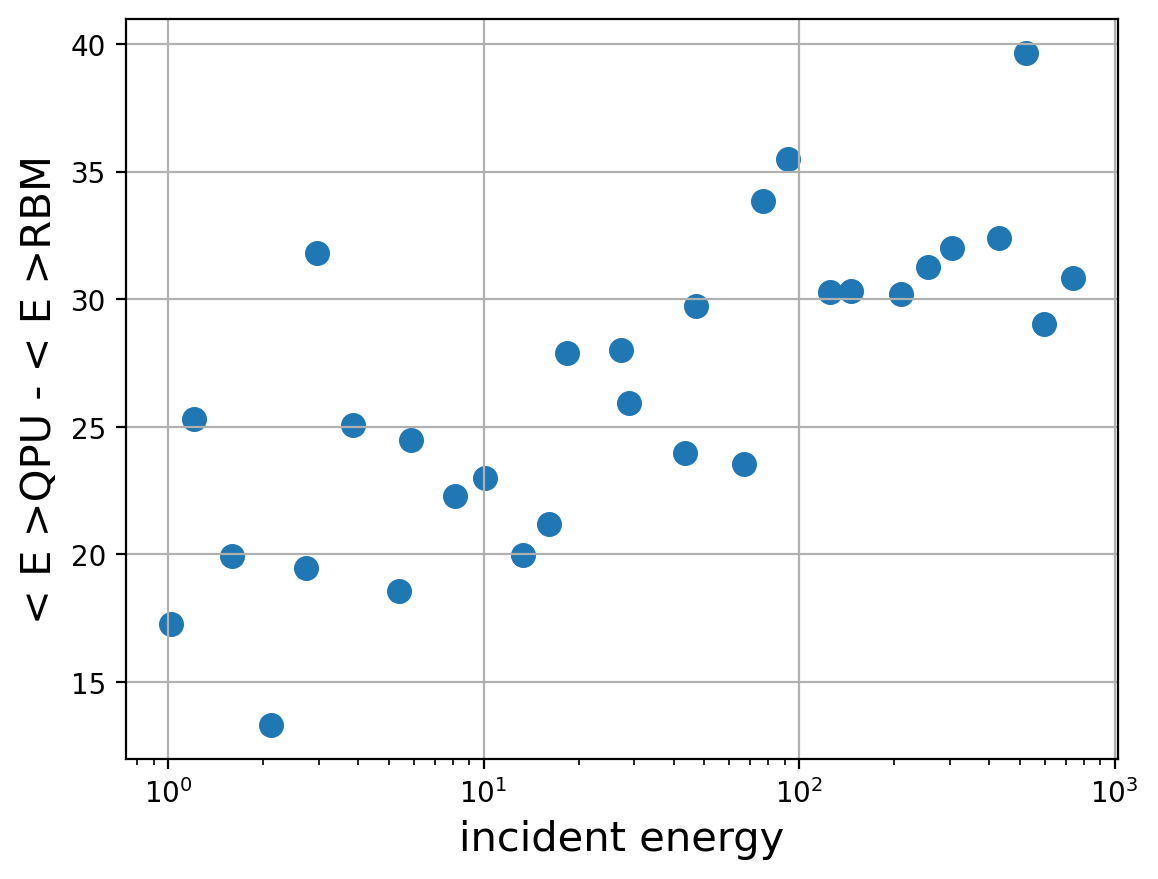

In [324]:
plt.scatter(qpu_dict['en'], np.array(qpu_dict['m']) - np.array(rbm_dict["m"]), lw=3)
plt.xscale("log")
plt.xlabel("incident energy", fontsize=15)
plt.ylabel("< E >QPU - < E >RBM", fontsize=15)
plt.grid(True) 
plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/DWAVE/Diff_energy_thrsh_{thrsh}.png')
plt.show()

In [18]:
np.savez(f'/home/javier/Projects/CaloQVAE/figs/DWAVE/RBM.npz', w01=engine.model.prior.weight_dict['01'].detach().cpu().numpy(), 
        w02=engine.model.prior.weight_dict['02'].detach().cpu().numpy(), 
        w03=engine.model.prior.weight_dict['03'].detach().cpu().numpy(),
        w12=engine.model.prior.weight_dict['12'].detach().cpu().numpy(),
        w13=engine.model.prior.weight_dict['13'].detach().cpu().numpy(),
        w23=engine.model.prior.weight_dict['23'].detach().cpu().numpy(),
        b0=engine.model.prior.bias_dict['0'].detach().cpu().numpy(),
        b1=engine.model.prior.bias_dict['1'].detach().cpu().numpy(),
        b2=engine.model.prior.bias_dict['2'].detach().cpu().numpy(),
        b3=engine.model.prior.bias_dict['3'].detach().cpu().numpy())

In [21]:
ll = np.load('/home/javier/Projects/CaloQVAE/figs/DWAVE/RBM.npz')

In [27]:
ll.files

['w01', 'w02', 'w03', 'w12', 'w13', 'w23', 'b0', 'b1', 'b2', 'b3']